In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)

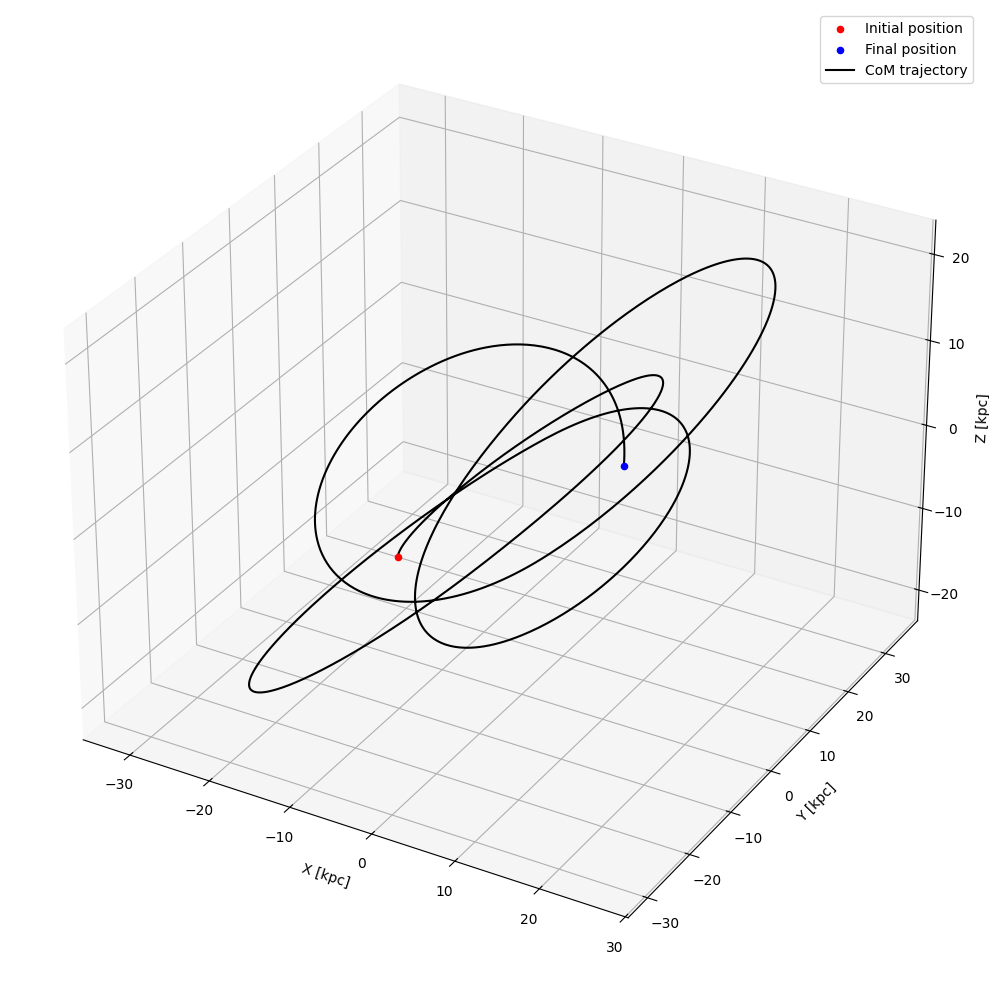

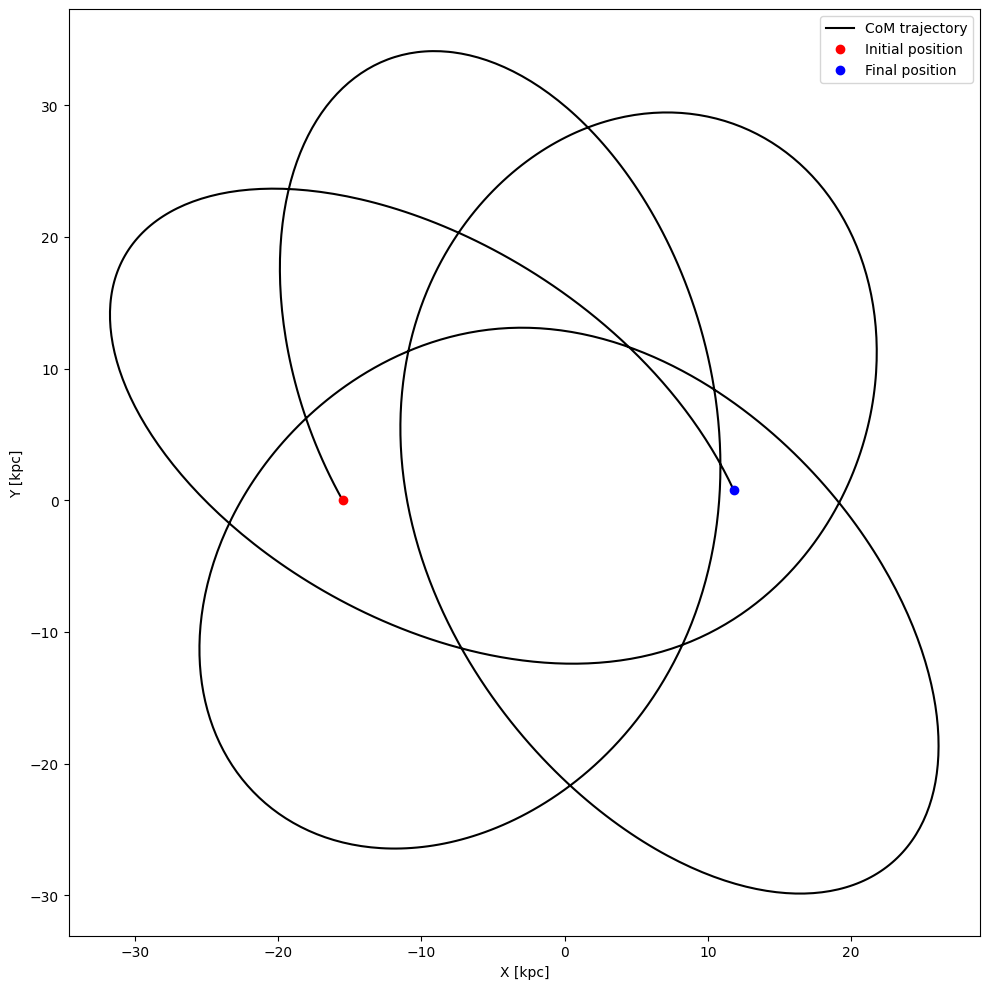

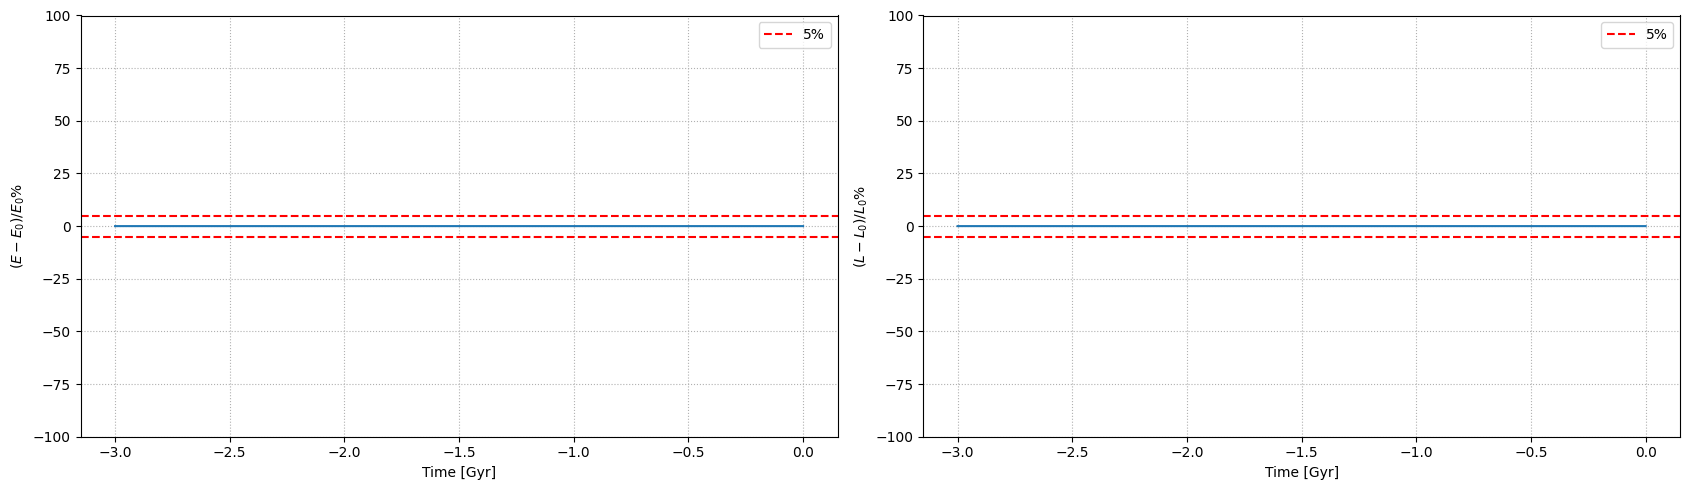

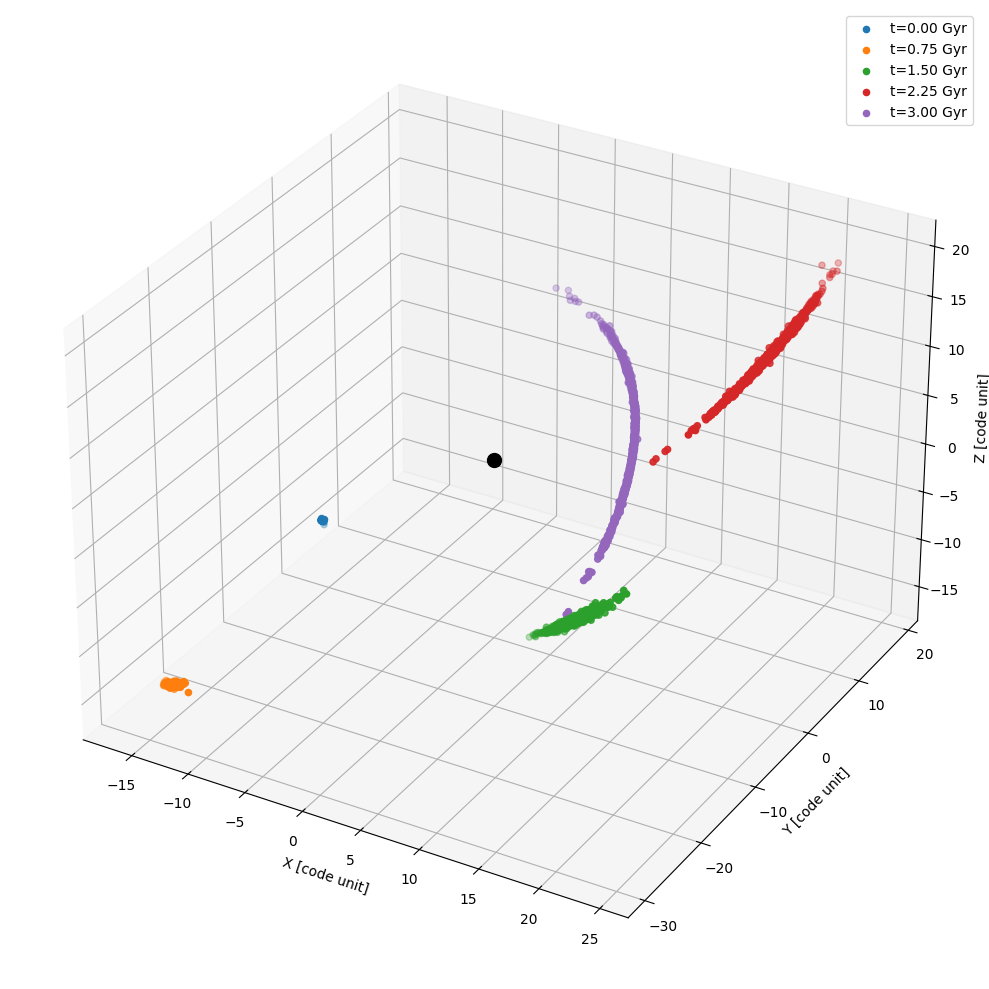

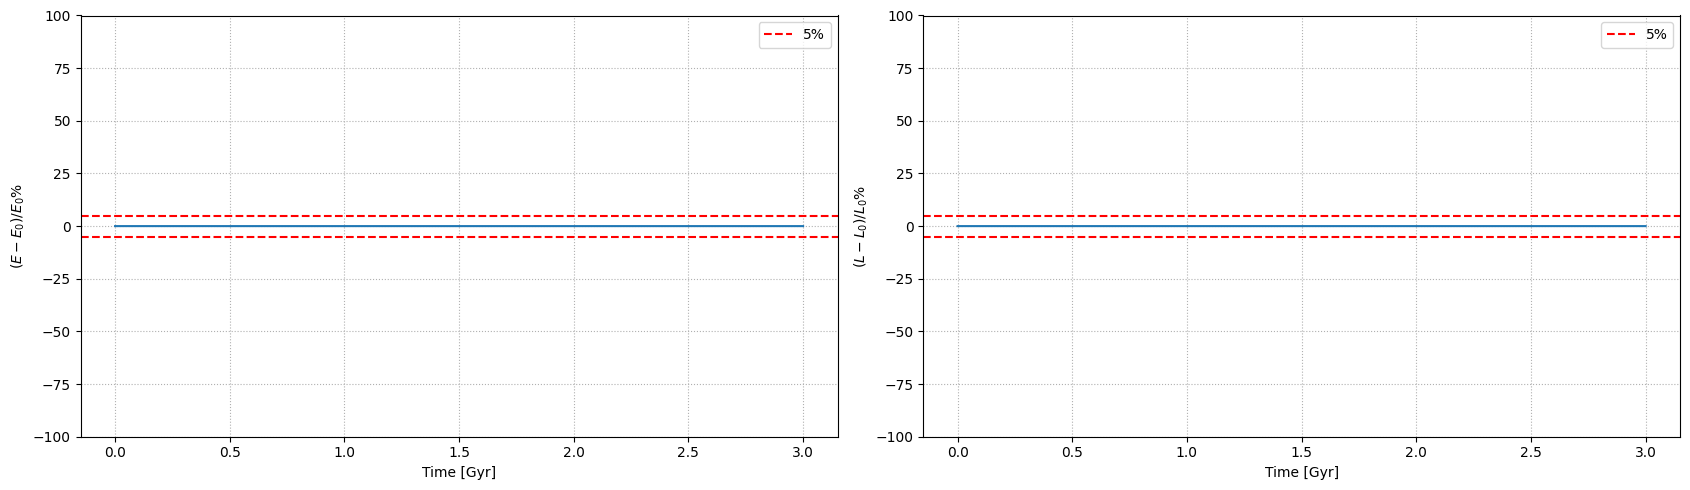

In [3]:
##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

##### Stream orbit plot####
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


In [4]:
config_com

SimulationConfig(N_particles=1, dimensions=3, return_snapshots=True, num_snapshots=1000, fixed_timestep=False, num_timesteps=1000, softening=np.float64(1.0000000000000003e-05), integrator=2, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(0, 2, 3), differentation_mode=1, diffrax_adjoint_method=0, num_checkpoints=100, progress_bar=False, gradient_horizon=0)

In [5]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 1000, 
#                          softening = (0.1 * u.pc).to(code_units.code_length).value,
#                          )

config_com = config_com._replace(return_snapshots=True,
                                 integrator = DIFFRAX_BACKEND,
                                 num_timesteps = 2000,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )



# @jit
def time_integration_NFW_mass_grad(Mvir,):

    phi1_min, phi1_max = -90, 10
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params._replace(
                    NFW_params=params.NFW_params._replace(
                        Mvir=Mvir 
                    # ),
                    # MN_params=params.MN_params._replace(
                        # M=params.MN_params.M * 2
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 8
    mask_correct_interpolation_forward = phi1_forward_valid > - 88

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward & mask_evaluate_inside_track_backward) + jnp.sum(mask_stream_forward &mask_evaluate_inside_track_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm


    return stream_coordinate_com_backward, stream_coordinate_com_forward, interp_tracks_backward, interp_tracks_forward, log_likelihood, phi1_backward_valid, phi1_forward_valid, mask_correct_interpolation_backward, mask_correct_interpolation_forward, valid_time_backward, valid_time_forward
    # return mask_stream_forward, mask_evaluate_inside_track_forward,stream_coordinate_com_forward, valid_time_forward, mask_correct_interpolation_backward, mask_correct_interpolation_forward, interp_tracks_backward, interp_tracks_forward


stream_coordinate_com_backward, stream_coordinate_com_forward, interpolate_coord_backward, interpolate_coord_forward, log_likelihood,  phi1_backward_valid, phi1_forward_valid, mask_correct_interpolation_backward, mask_correct_interpolation_forward, valid_time_backward, valid_time_forward = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir)
# mask_stream_forward, mask_evaluate_inside_track_forward,stream_coordinate_com_forward, valid_time_forward, mask_correct_interpolation_backward, mask_correct_interpolation_forward, interp_tracks_backward, interp_tracks_forward = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir)



In [6]:
plt.scatter(stream_data[:, 1][mask_stream_forward & mask_evaluate_inside_track_forward ], stream_data[:, 2][mask_stream_forward & mask_evaluate_inside_track_forward ], s=1)
plt.scatter(stream_coordinate_com_forward[:, 0,  1][valid_time_forward & mask_correct_interpolation_forward], stream_coordinate_com_forward[:, 0, 2][valid_time_forward & mask_correct_interpolation_forward], )
# data_to_interpolate = -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], 100000.0)


# interpolated_data = jnp.where(
#     valid_time_forward,
#     jnp.interp(
#         jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, data_to_interpolate, 100000.0), 
#         -stream_coordinate_com_forward[:, 0, 1], 
#         stream_coordinate_com_forward[:, 0, 2]),
#     0.)

plt.scatter(stream_data[:, 1][mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward], interp_tracks_forward[0][mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward], s=1, c='r')
plt.scatter(stream_coordinate_com_forward[:, 0,  1][valid_time_forward & mask_correct_interpolation_forward], stream_coordinate_com_forward[:, 0, 2][valid_time_forward & mask_correct_interpolation_forward], )

NameError: name 'mask_stream_forward' is not defined

In [23]:
stream_coordinate_com_backward.shape

(1000, 1, 6)

In [ ]:
interpolate_coord_backward[0][mask_stream_backward&mask_correct_interpolation_backward]

Array([-5.0610530e-01, -6.4145219e-01, -1.0000000e+05, -3.0278656e-01,
       -1.0000000e+05, -1.0000000e+05, -2.3946096e-01, -2.6444271e-01,
       -2.8129581e-01, -7.6529217e-01, -1.0000000e+05, -6.9984740e-01,
       -2.4018806e-01, -2.5524303e-01, -2.4479488e-01, -1.0000000e+05,
       -3.0279660e-01, -3.4646812e-01, -1.0000000e+05], dtype=float32)

IndexError: boolean index did not match shape of indexed array in index 0: got (1000,), expected (40,)

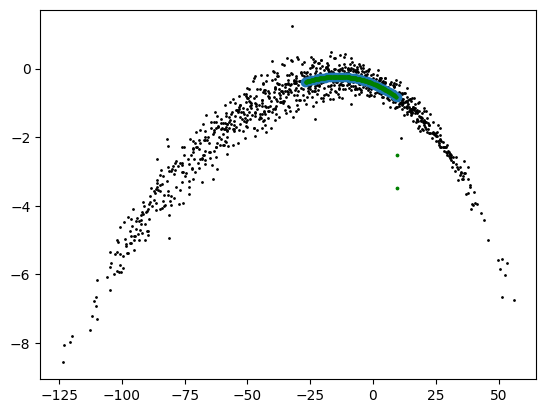

In [35]:
phi1_min, phi1_max = -90, 10
phi2_min, phi2_max = -8, 2
mask_window_backward = (stream_coordinate_com_backward[:, 0, 1]<phi1_max)&(stream_coordinate_com_backward[:, 0, 1]>phi1_min)&(stream_coordinate_com_backward[:, 0, 2]<phi2_max)&(stream_coordinate_com_backward[:, 0, 2]>phi2_min)
mask_diff_backward = (jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1)>0)
mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)
mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < 10)
stream_coordinate_com_backward = stream_coordinate_com_backward[mask_window_backward&mask_diff_backward]


plt.scatter(stream_data[:, 1], stream_data[:, 2], s=1, c='k')
plt.scatter(stream_coordinate_com_backward[:, :, 1], stream_coordinate_com_backward[:, :, 2], )
plt.scatter(stream_data[:, 1][mask_stream_backward&mask_evaluate_inside_track_backward], interpolate_coord_backward[0][mask_stream_backward&mask_evaluate_inside_track_backward], s=3, c='green')
plt.scatter(stream_coordinate_com_backward[:, :, 1][valid_time_backward & mask_correct_interpolation_backward], interpolate_coord_backward[0][mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward], s=10, c='orange')
plt.axvline(x=stream_coordinate_com_backward[-1, 0, 1], color='g', linestyle='--')

# mask_window_forward = (stream_coordinate_com_forward[:, 0, 1]<phi1_max)&(stream_coordinate_com_forward[:, 0, 1]>phi1_min)&(stream_coordinate_com_forward[:, 0, 2]<phi2_max)&(stream_coordinate_com_forward[:, 0, 2]>phi2_min)
# mask_diff_forward = (jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1)<0)
# mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)
# stream_coordinate_com_forward = stream_coordinate_com_forward[mask_window_forward&mask_diff_forward]

# mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]
# mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid))& (stream_data[:, 1] > -90)


# plt.scatter(stream_coordinate_com_forward[0, 0, 1], stream_coordinate_com_forward[0, 0, 2], s=100, c='g')
# plt.scatter(stream_coordinate_com_forward[:, :, 1], stream_coordinate_com_forward[:, :, 2], )
# plt.scatter(stream_data[:, 1][mask_stream_forward&mask_evaluate_inside_track_forward], interpolate_coord_forward[0][mask_stream_forward&mask_evaluate_inside_track_forward], s=3,)
# plt.axvline(x=stream_coordinate_com_forward[-1, 0, 1], color='g', linestyle='--')


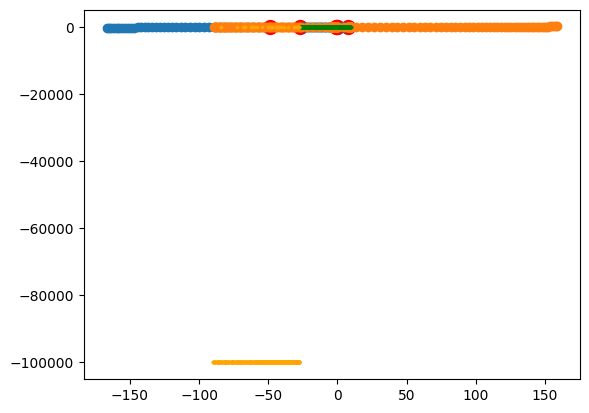

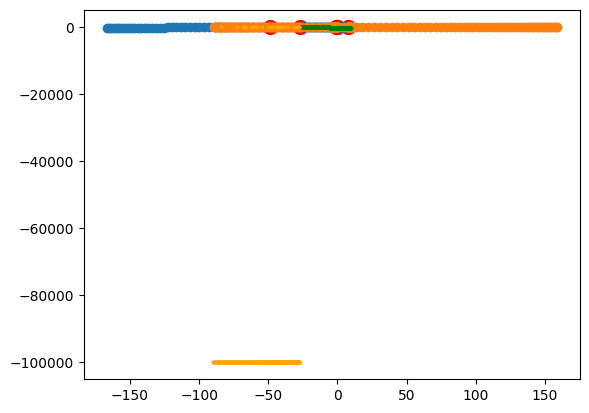

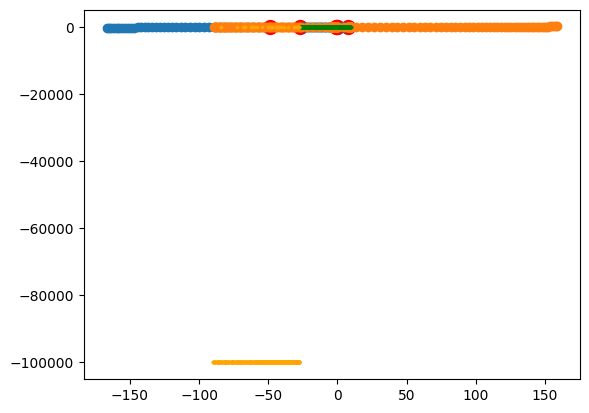

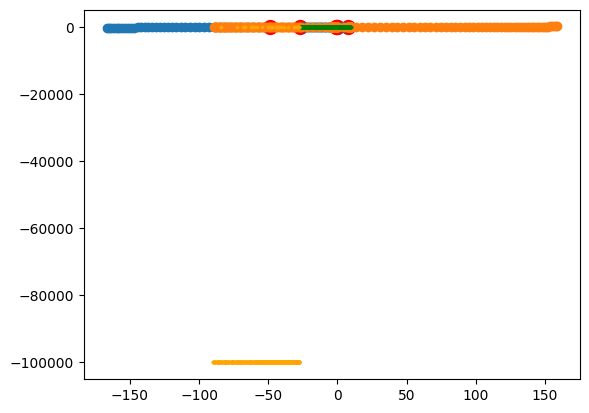

In [43]:
for i in [2, 3, 4, 5]:
    plt.scatter(stream_data[:, 1], stream_data[:, i], s=1, c='k')
    plt.scatter(stream_coordinate_com_backward[0, 1], stream_coordinate_com_backward[0, i], s=100, c='r')
    plt.scatter(stream_coordinate_com_backward[:, 1], stream_coordinate_com_backward[:, i], )
    plt.scatter(stream_coordinate_com_forward[:, 1], stream_coordinate_com_forward[:, i], )
    plt.scatter(stream_data[:, 1][mask_stream_backward&mask_evaluate_inside_track_backward], interpolate_coord_backward[i-2][mask_stream_backward&mask_evaluate_inside_track_backward], s=3, c='green')
    plt.scatter(stream_data[:, 1][mask_stream_forward&mask_evaluate_inside_track_forward], interpolate_coord_forward[i-2][mask_stream_forward&mask_evaluate_inside_track_forward], s=3, c='orange')
    plt.show()

In [33]:
import jax
import jax.numpy as jnp
from jax import jit, vmap

# --- Refactored helper utilities ------------------------------------------------

def _make_window_mask(phi1, phi2, phi1_min, phi1_max, phi2_min, phi2_max):
    """Window mask: True where (phi1,phi2) inside rectangular window."""
    return (phi1 > phi1_min) & (phi1 < phi1_max) & (phi2 > phi2_min) & (phi2 < phi2_max)

def _monotonic_run_mask(phi1_seq, direction='backward'):
    """
    Returns a boolean mask that is True while phi1 is strictly monotonic in the
    expected direction and stops (becomes False) after the first violation.
    direction: 'backward' means phi1 increases along time -> use differences > 0
               'forward'  means phi1 decreases along time -> use differences < 0
    """
    if direction == 'backward':
        diffs_ok = jnp.ediff1d(phi1_seq, to_begin=1) > 0
    else:
        diffs_ok = jnp.ediff1d(phi1_seq, to_begin=-1) < 0
    # cumprod preserves True until first False
    return jnp.cumprod(diffs_ok, dtype=bool)

def _safe_interp(x_query, x_known, y_known, fill_value=jnp.nan):
    """
    Interpolate y_known(x_known) onto x_query using jnp.interp.
    jnp.interp expects x_known sorted ascending. We rely on masking + sentinel
    values to ensure monotonic sorting of x_known. Returns fill_value where
    x_query is outside interpolation domain.
    """
    return jnp.interp(x_query, x_known, y_known, left=fill_value, right=fill_value)

def safe_interpolate_direction(track, phi1_known, valid_mask, phi1_obs, coord_indices, direction):
    """
    Clean interpolation without sentinel artifacts.
    Only interpolate within valid (monotonic) phi1 range.
    Out-of-range queries are clipped to the valid domain boundaries.
    """
    # Select valid segments
    phi1_valid = phi1_known[valid_mask]
    track_valid = track[valid_mask, :]

    # Ensure strictly monotonic order for jnp.interp
    if direction == "forward":
        # forward φ1 decreases, so flip both φ1 and y
        phi1_valid = -phi1_valid
        phi1_obs = -phi1_obs
        track_valid = track_valid

    # Clip queries to valid range (avoid extrapolation)
    phi1_min, phi1_max = jnp.min(phi1_valid), jnp.max(phi1_valid)
    phi1_obs_clipped = jnp.clip(phi1_obs, phi1_min, phi1_max)

    def interp_single(coord_idx):
        y_valid = track_valid[:, coord_idx]
        return jnp.interp(phi1_obs_clipped, phi1_valid, y_valid)

    return vmap(interp_single)(coord_indices)

# --- Main refactor: single function with symmetric forward/backward handling ----

@jit
def time_integration_NFW_mass_grad(Mvir):
    # window limits
    phi1_min, phi1_max = -90., 10.
    phi2_min, phi2_max = -8., 2.

    coord_indices = jnp.array([2, 3, 4, 5])   # coords we want to interpolate (phi1, phi2, dist, pm, ...)

    # final COM state (converted to code units)
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5, -254.5, -90.3]]) * (u.km / u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot])

    initial_state_com = construct_initial_state(pos_com_final, vel_com_final)

    # helper that integrates & projects a single t_end
    @jit
    def integrate_project_for_tend(t_end):
        new_params = params._replace(
            NFW_params=params.NFW_params._replace(Mvir=Mvir),
            t_end=t_end
        )
        snaps = time_integration(initial_state_com, mass_com, config=config_com, params=new_params)
        # snaps.states shape assumed (nt, Nparticles, ncoords) — original used [:,0,...], keep same
        projected = jax.vmap(projection_on_GD1, in_axes=(0, None))(snaps.states, code_units)
        return projected  # shape (nt, Nparticles, nfeatures)

    # two directions: backward and forward integration times
    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])

    # Integrate both ends
    stream_coords_two = vmap(integrate_project_for_tend)(t_end_array)
    stream_backward = stream_coords_two[0]   # (nt_b, Np, feats)
    stream_forward = stream_coords_two[1]    # (nt_f, Np, feats)

    # pick the track of the COM particle (like original: [:,0,...])
    track_b = stream_backward[:, 0, :]   # shape (nt_b, nfeatures)
    track_f = stream_forward[:, 0, :]    # shape (nt_f, nfeatures)

    # phi1, phi2 sequences for masks
    phi1_b = track_b[:, 1]
    phi2_b = track_b[:, 2]
    phi1_f = track_f[:, 1]
    phi2_f = track_f[:, 2]

    # window masks
    window_b = _make_window_mask(phi1_b, phi2_b, phi1_min, phi1_max, phi2_min, phi2_max)
    window_f = _make_window_mask(phi1_f, phi2_f, phi1_min, phi1_max, phi2_min, phi2_max)

    # monotonic run masks (stop after first violation)
    monotonic_b = _monotonic_run_mask(phi1_b, direction='backward')
    monotonic_f = _monotonic_run_mask(phi1_f, direction='forward')

    valid_b = window_b & monotonic_b
    valid_f = window_f & monotonic_f

    # Build phi1 arrays for interpolation: for monotonic behavior we need sorted x_known.
    # For backward: phi1 increases along index, so x_known = phi1_b[valid_b] ascending
    # For forward: phi1 decreases along index, to make ascending we flip sign.
    # We will place sentinel values outside [phi1_min, phi1_max] when not valid so jnp.interp sees correct sorted array length.
    # Use finite but extreme sentinels so x_known remains monotonic.
    sentinel_large = 1e6
    sentinel_small = -1e6

    # phi1_known arrays (length = nt_b / nt_f)
    phi1_known_b = jnp.where(valid_b, phi1_b, sentinel_large)    # valid ones keep real values, others huge
    phi1_known_f = jnp.where(valid_f, phi1_f, sentinel_small)   # valid keep real, others very negative

    # For each coord index build y_known arrays (same shape as phi1_known)
    def _coord_series(track, valid_mask, coord_idx, fill_value):
        seq = jnp.where(valid_mask, track[:, coord_idx], fill_value)
        return seq

    # Interpolation queries: decide which stream_data points to use per direction
    # stream_data columns: we assume index 1 is phi1 as in your original code
    phi1_data = stream_data[:, 1]

    mask_stream_b = phi1_data > track_b[0, 1]   # same as original: points "beyond" initial COM phi1
    mask_stream_f = phi1_data < track_f[0, 1]

    # evaluate only those inside the track extents (like original)
    phi1_b_max = jnp.max(phi1_known_b)
    phi1_f_min = jnp.min(phi1_known_f)

    mask_eval_inside_b = (phi1_data < phi1_b_max) & (phi1_data < phi1_max)
    mask_eval_inside_f = (phi1_data > phi1_f_min) & (phi1_data > phi1_min)

    # combined masks for queries
    query_mask_b = mask_stream_b & mask_eval_inside_b
    query_mask_f = mask_stream_f & mask_eval_inside_f

    # prepare query arrays for interpolation (set queries outside mask to some value outside domain so interp returns sentinel fill)
    query_vals_b = jnp.where(query_mask_b, phi1_data, sentinel_large)   # outside -> big (beyond phi1_known_b left/right)
    query_vals_f = jnp.where(query_mask_f, phi1_data, sentinel_small)

    # For forward interpolation we will flip sign so phi1_known_f becomes ascending
    neg_query_vals_f = -query_vals_f
    neg_phi1_known_f = -phi1_known_f

    # Interpolate all requested coordinates using vmap over coordinate indices
    def interp_for_direction(track, phi1_known, query_vals, phi1_known_flipped=False):
        """
        Returns interpolated tracks for coord_indices:
          -> shape (n_coords, n_data)
        If phi1_known_flipped is True, we assume phi1_known was flipped with sign to make ascending.
        """
        def interp_single(coord_idx):
            fill_val = jnp.nan
            y_known = _coord_series(track, jnp.ones_like(phi1_known, dtype=bool), coord_idx, fill_val)
            # but we must mask y_known using valid mask via setting to fill_val where phi1_known sentinel present:
            # Recompute valid_mask from phi1_known sentinel positions
            if phi1_known_flipped:
                valid_mask = neg_phi1_known_f != -sentinel_small
            else:
                valid_mask = phi1_known != sentinel_large
            y_known_masked = jnp.where(valid_mask, y_known, fill_val)
            return _safe_interp(query_vals, phi1_known, y_known_masked, fill_value=fill_val)
        return vmap(interp_single)(coord_indices)

    # Clean version — no extrapolation artifacts
    interp_b = safe_interpolate_direction(
        track_b, phi1_b, valid_b, stream_data[:, 1], coord_indices, direction="backward"
    )
    interp_f = safe_interpolate_direction(
        track_f, phi1_f, valid_f, stream_data[:, 1], coord_indices, direction="forward"
    )


    # Now compute residuals & chi2
    data_coords = stream_data[:, coord_indices].T  # shape (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2.])  # as in your original code; adjust ordering to match coord_indices

    # Build residual masks and compute residuals only where queries were valid
    valid_mask_b_data = query_mask_b  # boolean mask over data points
    valid_mask_f_data = query_mask_f

    # Broadcast masks to shape (n_coords, n_data)
    vb = valid_mask_b_data[None, :]
    vf = valid_mask_f_data[None, :]

    # Where interpolation returned fill (nan), replace with zero residual by masking later
    resid_b = jnp.where(vb, (data_coords - interp_b) / (sigma[:, None]), 0.0)
    resid_f = jnp.where(vf, (data_coords - interp_f) / (sigma[:, None]), 0.0)

    chi2_b = jnp.sum(resid_b ** 2)
    chi2_f = jnp.sum(resid_f ** 2)
    chi2 = chi2_b + chi2_f

    n_valid = jnp.sum(valid_mask_b_data) + jnp.sum(valid_mask_f_data)
    log_norm = -0.5 * n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma ** 2))
    log_likelihood = -0.5 * chi2 + log_norm

    # Return comparable outputs to original function
    return (track_b, track_f, interp_b, interp_f, log_likelihood, phi1_known_b, phi1_known_f)

# --- Example call (unchanged semantics) ------------------------------------------
stream_coordinate_com_backward, stream_coordinate_com_forward, \
interp_tracks_backward, interp_tracks_forward, \
log_likelihood, phi1_backward_valid, phi1_forward_valid = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir)


NonConcreteBooleanIndexError: Array boolean indices must be concrete; got bool[1000]

See https://docs.jax.dev/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

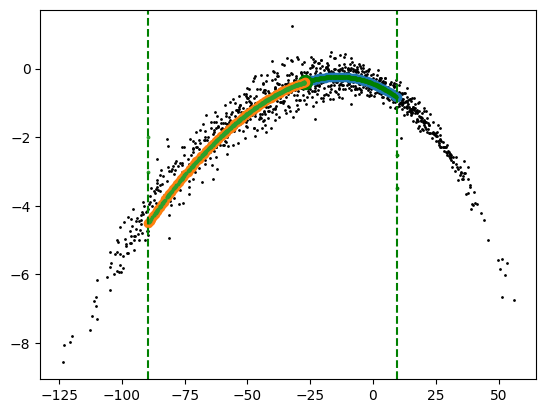

In [29]:
phi1_min, phi1_max = -90, 10
phi2_min, phi2_max = -8, 2
mask_window_backward = (stream_coordinate_com_backward[:, 1]<phi1_max)&(stream_coordinate_com_backward[:, 1]>phi1_min)&(stream_coordinate_com_backward[:,  2]<phi2_max)&(stream_coordinate_com_backward[:,  2]>phi2_min)
mask_diff_backward = (jnp.ediff1d(stream_coordinate_com_backward[:, 1], to_begin=1)>0)
mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)
mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 1]
mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < 10)
stream_coordinate_com_backward = stream_coordinate_com_backward[mask_window_backward&mask_diff_backward]


plt.scatter(stream_data[:, 1], stream_data[:, 2], s=1, c='k')
plt.scatter(stream_coordinate_com_backward[:, 1], stream_coordinate_com_backward[:, 2], )
plt.scatter(stream_data[:, 1][mask_stream_backward&mask_evaluate_inside_track_backward], interpolate_coord_backward[0][mask_stream_backward&mask_evaluate_inside_track_backward], s=3, c='green')
plt.axvline(x=stream_coordinate_com_backward[-1, 1], color='g', linestyle='--')

mask_window_forward = (stream_coordinate_com_forward[:, 1]<phi1_max)&(stream_coordinate_com_forward[:, 1]>phi1_min)&(stream_coordinate_com_forward[:,  2]<phi2_max)&(stream_coordinate_com_forward[:, 2]>phi2_min)
mask_diff_forward = (jnp.ediff1d(stream_coordinate_com_forward[:, 1], to_begin=-1)<0)
mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)
stream_coordinate_com_forward = stream_coordinate_com_forward[mask_window_forward&mask_diff_forward]

mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 1]
mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid))& (stream_data[:, 1] > -90)


plt.scatter(stream_coordinate_com_forward[0, 1], stream_coordinate_com_forward[0, 2], s=100, c='g')
plt.scatter(stream_coordinate_com_forward[:, 1], stream_coordinate_com_forward[:, 2], )
plt.scatter(stream_data[:, 1][mask_stream_forward&mask_evaluate_inside_track_forward], interpolate_coord_forward[0][mask_stream_forward&mask_evaluate_inside_track_forward], s=3,)
plt.axvline(x=stream_coordinate_com_forward[-1, 1], color='g', linestyle='--')


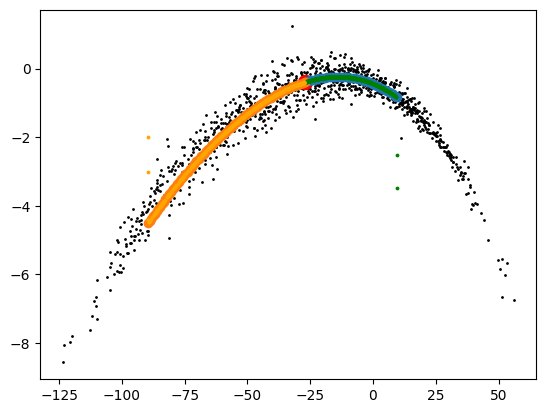

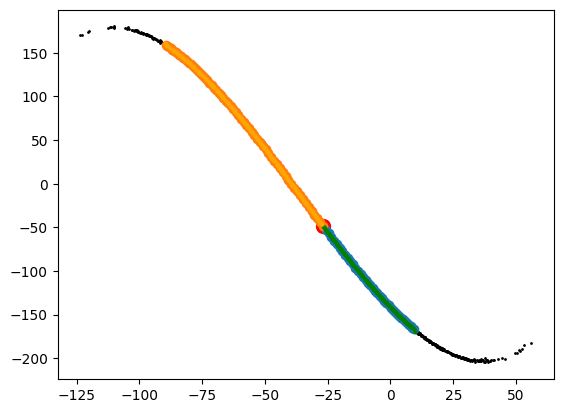

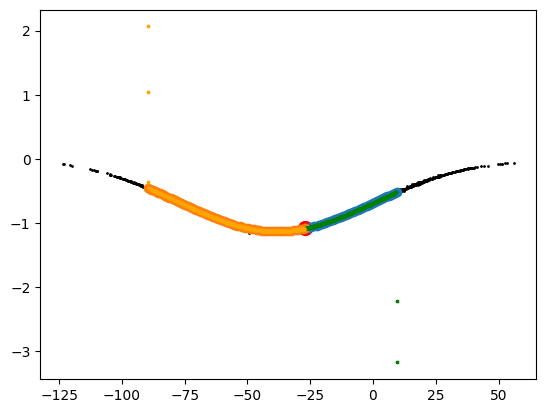

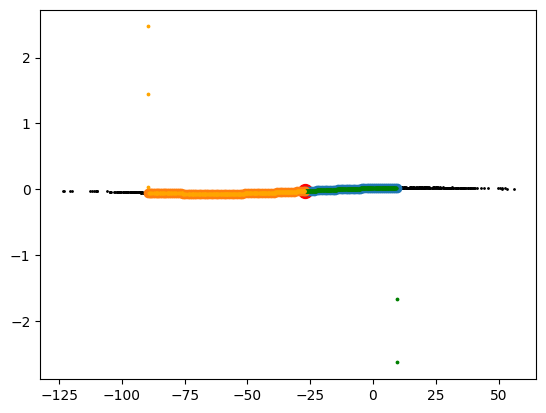

In [31]:
for i in [2, 3, 4, 5]:
    plt.scatter(stream_data[:, 1], stream_data[:, i], s=1, c='k')
    plt.scatter(stream_coordinate_com_backward[0, 1], stream_coordinate_com_backward[0, i], s=100, c='r')
    plt.scatter(stream_coordinate_com_backward[:, 1], stream_coordinate_com_backward[:, i], )
    plt.scatter(stream_coordinate_com_forward[:, 1], stream_coordinate_com_forward[:, i], )
    plt.scatter(stream_data[:, 1][mask_stream_backward&mask_evaluate_inside_track_backward], interpolate_coord_backward[i-2][mask_stream_backward&mask_evaluate_inside_track_backward], s=3, c='green')
    plt.scatter(stream_data[:, 1][mask_stream_forward&mask_evaluate_inside_track_forward], interpolate_coord_forward[i-2][mask_stream_forward&mask_evaluate_inside_track_forward], s=3, c='orange')
    plt.show()

# Fit everythig 


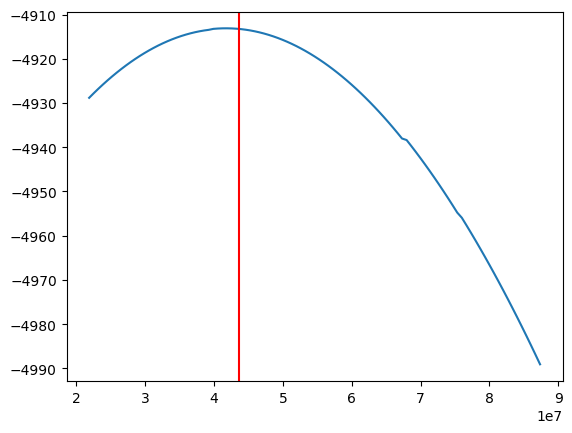

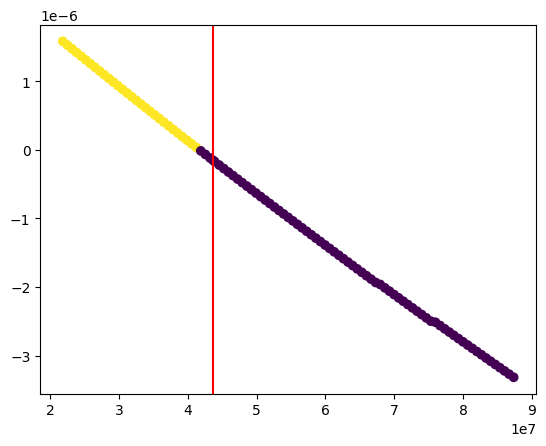

In [ ]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_NFW_mass_grad(Mvir, coord_indices=jnp.array([2, 3, 4, 5])):
    
    phi1_min, phi1_max = -90, 10
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params._replace(
                    NFW_params=params.NFW_params._replace(
                        Mvir=Mvir 
                    # ),
                    # MN_params=params.MN_params._replace(
                        # M=params.MN_params.M * 2
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]
    

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 8
    mask_correct_interpolation_forward = phi1_forward_valid > - 88

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward & mask_evaluate_inside_track_backward) + jnp.sum(mask_stream_forward &mask_evaluate_inside_track_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood


log_likelihood = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir*0.1)
Mvir = jnp.linspace(params.NFW_params.Mvir*0.5, params.NFW_params.Mvir*2, 99)
Mvir = jnp.append(Mvir, jnp.array([params.NFW_params.Mvir]))
Mvir = jnp.sort(Mvir)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir)
plt.plot(Mvir, chi2)
plt.axvline(params.NFW_params.Mvir, color='r')
plt.show()
plt.scatter(Mvir, grad, c=grad>0)
plt.axvline(params.NFW_params.Mvir, color='r')


# R_s

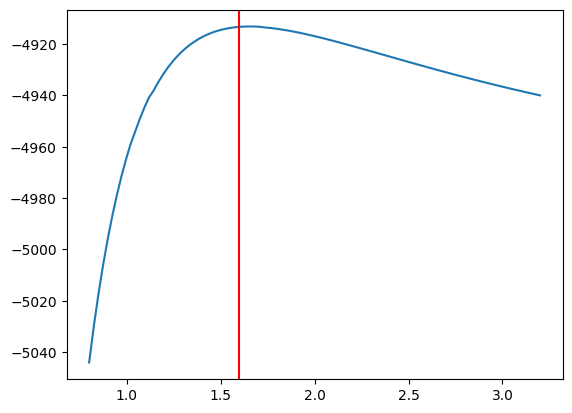

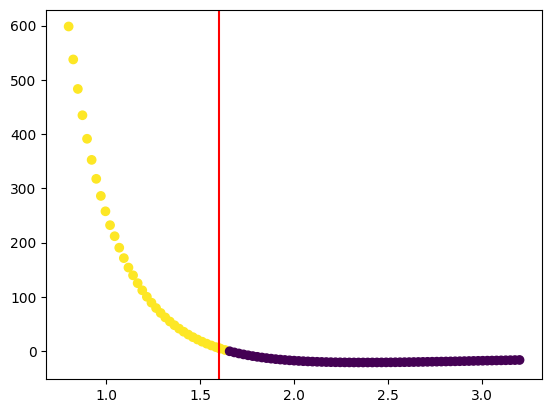

In [24]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_r_s_grad(r_s, coord_indices=jnp.array([2, 3, 4, 5])):
    phi1_min, phi1_max = -90, 10
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params._replace(
                    NFW_params=params.NFW_params._replace(
                    r_s=r_s
                    # ),
                    # MN_params=params.MN_params._replace(
                        # M=params.MN_params.M * 2
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]
    

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 8
    mask_correct_interpolation_forward = phi1_forward_valid > - 88

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward & mask_evaluate_inside_track_backward) + jnp.sum(mask_stream_forward &mask_evaluate_inside_track_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    

    return log_likelihood


log_likelihood = time_integration_r_s_grad(r_s=params.NFW_params.r_s*0.1)
r_s = jnp.linspace(params.NFW_params.r_s*0.5, params.NFW_params.r_s*2, 99)
r_s = jnp.append(r_s, jnp.array([params.NFW_params.r_s]))
r_s = jnp.sort(r_s)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_r_s_grad))(r_s)
plt.plot(r_s, chi2)
plt.axvline(params.NFW_params.r_s, color='r')
plt.show()
plt.scatter(r_s, grad, c=grad>0)
plt.axvline(params.NFW_params.r_s, color='r')


# M_MN

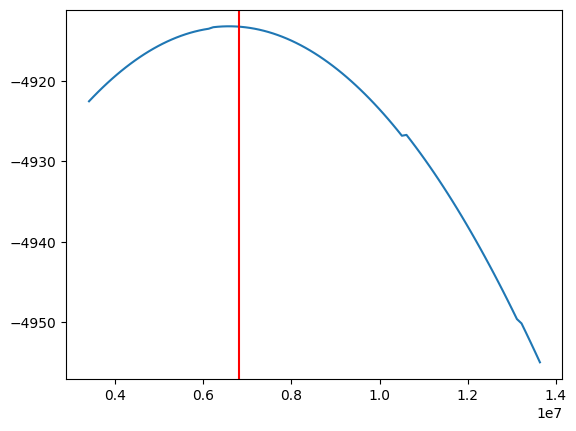

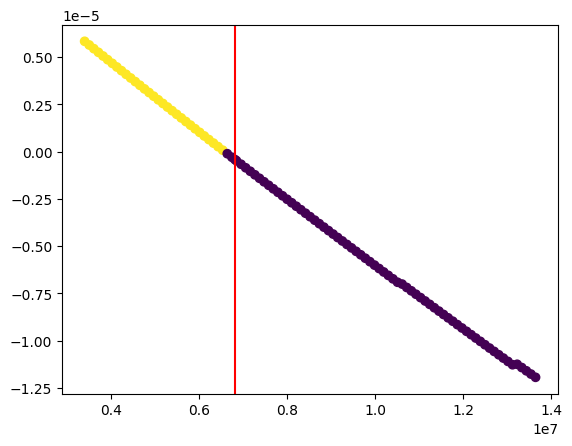

In [46]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_MN_mass_grad(M_MN, coord_indices=jnp.array([2, 3, 4, 5])):

    phi1_min, phi1_max = -90, 10
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params._replace(
                    # NFW_params=params.NFW_params._replace(
                    #     Mvir=Mvir 
                    # ),
                    MN_params=params.MN_params._replace(
                        M=M_MN
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 8
    mask_correct_interpolation_forward = phi1_forward_valid > - 88

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward & mask_evaluate_inside_track_backward) + jnp.sum(mask_stream_forward &mask_evaluate_inside_track_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood


log_likelihood = time_integration_MN_mass_grad(M_MN=params.MN_params.M*0.1)
M_MN = jnp.linspace(params.MN_params.M*0.5, params.MN_params.M*2, 99)
M_MN = jnp.append(M_MN, jnp.array([params.MN_params.M]))
M_MN = jnp.sort(M_MN)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_MN_mass_grad))(M_MN)
plt.plot(M_MN, chi2)
plt.axvline(params.MN_params.M, color='r')
plt.show()
plt.scatter(M_MN, grad, c=grad>0)
plt.axvline(params.MN_params.M, color='r')


# a MN

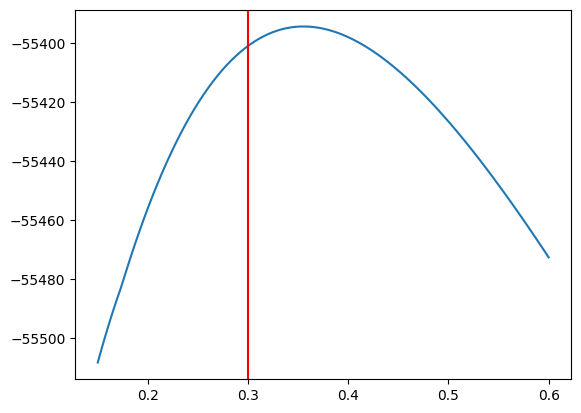

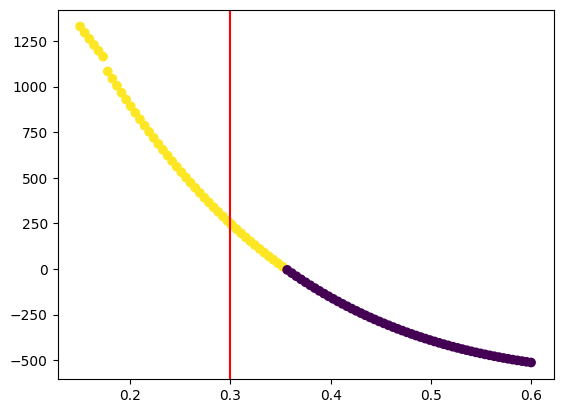

In [ ]:
@partial(jit, static_argnames=['coord_indices'])
def time_integration_a_MN_grad(a_MN, coord_indices=jnp.array([2, 3, 4, 5])):

    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(a_MN, t_end):
        new_params = params._replace(
                    MN_params=params.MN_params._replace(
                        a=a_MN
                    ), t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.1 * u.Gyr.to(code_units.code_time)
    a_MN_array = jnp.array([a_MN, a_MN])
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(a_MN_array, t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood


log_likelihood = time_integration_a_MN_grad(a_MN=params.MN_params.a*0.1)
a_MN = jnp.linspace(params.MN_params.a*0.5, params.MN_params.a*2, 99)
a_MN = jnp.append(a_MN, jnp.array([params.MN_params.a]))
a_MN = jnp.sort(a_MN)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_a_MN_grad))(a_MN)
plt.plot(a_MN, chi2)
plt.axvline(params.MN_params.a, color='r')
plt.show()
plt.scatter(a_MN, grad, c=grad>0)
plt.axvline(params.MN_params.a, color='r')


# TWO dimensional (masses)

In [5]:
params_sim = params

@jit
def run_simulation(Mvir, M_MN):

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass)
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > - 95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward & mask_evaluate_inside_track_backward) + jnp.sum(mask_stream_forward &mask_evaluate_inside_track_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
M_MN = (params.MN_params.M*(3/4) * u.Msun).to(code_units.code_mass).value
loss, grad = jax.value_and_grad(run_simulation, )(Mvir, M_MN) 
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  
n_sim = 200

M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/5) * code_units.code_mass.to(u.Msun), params.NFW_params.Mvir*(5) * code_units.code_mass.to(u.Msun), n_sim-1) # Adjust range based on expected values
M_MN_values = jnp.linspace(params.MN_params.M*(1/5) * code_units.code_mass.to(u.Msun), params.MN_params.M*(5) * code_units.code_mass.to(u.Msun), n_sim-1) # Adjust range based on expected values

M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)])])  # Append the true Mvir value
M_MN_values = jnp.concatenate([M_MN_values, jnp.array([params.MN_params.M * code_units.code_mass.to(u.Msun)])])  # Append the true M_MN value
# Ensure both arrays are sorted
# M_tot_values = jnp.log10(jnp.sort(M_tot_values))
# M_MN_values = jnp.sort(M_MN_values)

M_tot_values = jnp.sort(M_tot_values)
M_MN_values = jnp.sort(M_MN_values)

# Create a meshgrid
M_tot_grid, M_MN_grid = jnp.meshgrid(M_tot_values, M_MN_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
M_MN_flat = M_MN_grid.flatten()

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.lax.with_sharding_constraint(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
M_MN_sharded = jax.lax.with_sharding_constraint(M_MN_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, M_MN = input
    return jax.value_and_grad(run_simulation, argnums=(0, 1))(Mvir, M_MN)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, M_MN_sharded, ), 
                         batch_size=5_000)

loss = loss.reshape(M_tot_grid.shape)

Gradient of the total mass of the Mvir of NFW:
 4.167884e-09
Loss:
 -7446.2944


Text(0.5, 1.0, 'loss_landscape')

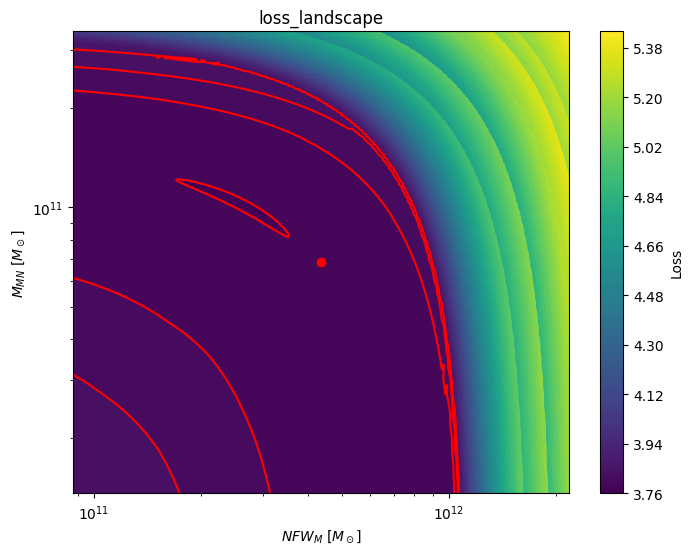

In [6]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
CS = plt.contourf(M_tot_values, M_MN_values, jnp.log10(-loss.T), levels=100, cmap="viridis")
plt.colorbar(label="Loss")

CS2 = plt.contour(CS, levels=CS.levels[:5:], colors='r')

plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.MN_params.M * code_units.code_mass.to(u.Msun),color="red", label="True values")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$M_{MN}$ [$M_\odot$]")
plt.title("loss_landscape")

In [67]:
# import hvplot.xarray  # noqa
# import numpy as np
# import xarray as xr

# ds = xr.DataArray(loss.T, coords=[('M_tot_values', M_tot_values), ('M_MN_values', M_MN_values)], name='loss').to_dataset()
# ds.hvplot.contour(x='M_tot_values', y='M_MN_values', z='loss', levels=1000, cmap='viridis', colorbar=True)

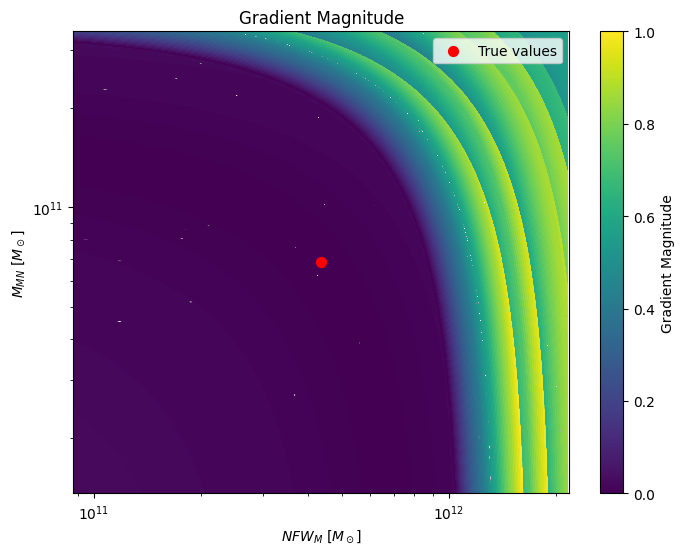

In [19]:
# Calculate gradient magnitude at each point
grad_magnitude = jnp.sqrt(grad[0]**2 + grad[1]**2)
grad_magnitude = grad_magnitude.reshape(M_tot_grid.shape)

plt.figure(figsize=(8, 6))
plt.imshow(grad_magnitude.T, 
           extent=(M_tot_values.min(), M_tot_values.max(), 
                  M_MN_values.min(), M_MN_values.max()), 
           origin='lower', aspect='auto', cmap='viridis')

plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
           params.MN_params.M * code_units.code_mass.to(u.Msun),
           color="red", label="True values", s=50)

plt.colorbar(label="Gradient Magnitude")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$M_{MN}$ [$M_\odot$]")
plt.title("Gradient Magnitude")
plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


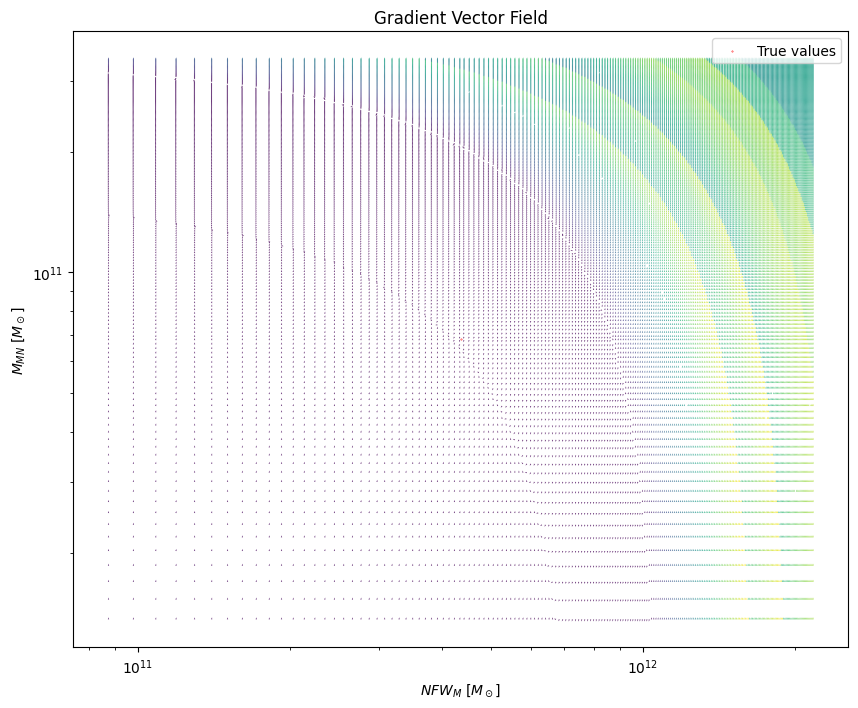

In [29]:
# Subsample for cleaner arrow plot
skip = 5 # Plot every 5th arrow to avoid clutter
M_tot_sub = M_tot_grid[::skip, ::skip]
M_MN_sub = M_MN_grid[::skip, ::skip]
grad_mvir_sub = grad[0].reshape(M_tot_grid.shape)[::skip, ::skip]
grad_mmn_sub = grad[1].reshape(M_tot_grid.shape)[::skip, ::skip]

plt.figure(figsize=(10, 8))
# Normalize the gradients
grad_magnitude = jnp.sqrt(grad_mvir_sub**2 + grad_mmn_sub**2)
grad_mvir_norm = jnp.where(grad_magnitude > 0, grad_mvir_sub / grad_magnitude, 0)
grad_mmn_norm = jnp.where(grad_magnitude > 0, grad_mmn_sub / grad_magnitude, 0)

plt.figure(figsize=(10, 8))
plt.quiver(M_tot_sub, M_MN_sub, grad_mvir_norm, grad_mmn_norm, 
           grad_magnitude, alpha=0.8, cmap='viridis')

plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
           params.MN_params.M * code_units.code_mass.to(u.Msun),
           color="red", label="True values", s=0.1, zorder=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$M_{MN}$ [$M_\odot$]")
plt.title("Gradient Vector Field")
plt.legend()
plt.show()

In [102]:
# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

# @jit
def run_simulation( y, return_residual=False):

    Mvir, M_MN = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass)
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > - 95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    return chi2
    # if return_residual:
    #     return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    # else:
    #     return chi2

# from jax.scipy import optimize
# res = optimize.minimize(
#     fun = run_simulation,
#     x0 = jnp.array([params.NFW_params.Mvir*(2) * code_units.code_mass.to(u.Msun), params.MN_params.M * (2)* code_units.code_mass.to(u.Msun)]),
#     method="BFGS"
# )


In [87]:

from optimistix import least_squares
import optimistix

res = optimistix.least_squares(
    fn=run_simulation,
    solver=optimistix.LevenbergMarquardt(rtol=1e-10, atol=1e-10),
    # solver = optimistix.GradientDescent(learning_rate=1e-5, rtol=1e-8, atol=1e-8),
    # solver = optimistix.BFGS(rtol=1e-10, atol=1e-10),
    y0=jnp.array([jnp.log10(params.NFW_params.Mvir*(2) * code_units.code_mass.to(u.Msun)), jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun))]),
    )

In [106]:
from optimistix import least_squares
import optimistix

config_com = config_com._replace(diffrax_adjoint_method=RECURSIVECHECKPOINTADJOING,)
res = optimistix.minimise(
    fn=run_simulation,
    # solver=optimistix.LevenbergMarquardt(rtol=1e-10, atol=1e-10),
    solver = optimistix.GradientDescent(learning_rate=1e-5, rtol=1e-5, atol=1e-5),
    # solver = optimistix.BFGS(rtol=1e-10, atol=1e-10),
    y0=jnp.array([jnp.log10(params.NFW_params.Mvir*(2) * code_units.code_mass.to(u.Msun)), jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun))]),
    args=({'return_residual':False},)
    )

E1008 14:22:54.682102 1604787 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/pytho

EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
    self._run_once()
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
    handle._run()
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue
    await self.process_one()
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 508, in process_one
    await dispatch(*args)
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
    await result
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 368, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
    reply_content = await reply_content
                    ^^^^^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 455, in do_execute
    res = shell.run_cell(
          ^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 577, in run_cell
    return super().run_cell(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
    result = self._run_cell(
             ^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
    result = runner(coro)
             ^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1604787/938802296.py", line 5, in <module>
    res = optimistix.minimise(
          ^^^^^^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/optimistix/_minimise.py", line 107, in minimise
    return iterative_solve(
           ^^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/optimistix/_iterate.py", line 351, in iterative_solve
    sol = result.error_if(sol, result != RESULTS.successful)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

equinox.EquinoxRuntimeError: The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


In [88]:
res.value

Array([11.4392605, 10.995132 ], dtype=float32)

In [ ]:
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
hessian = jax.jacfwd(jax.jacfwd(run_simulation))(res.value, False)
# hessian = jax.hessian(run_simulation)(res.value, None)

In [90]:
hessian

Array([[3210.588 , 5144.9883],
       [5144.9883, 8659.5625]], dtype=float32)

In [93]:
fisher_info = - hessian
covariance = jnp.linalg.inv(fisher_info)

/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


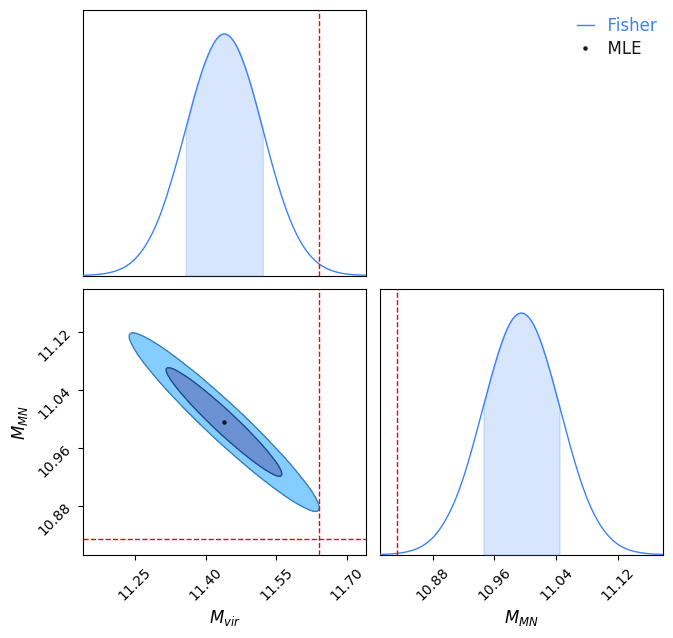

In [94]:
from chainconsumer import Chain, ChainConsumer, Truth

c = ChainConsumer()
chain = Chain.from_covariance(mean=res.value, covariance=covariance, columns=["$M_{vir}$", "$M_{MN}$"], name='Fisher')
c.add_chain(chain)
c.add_truth(Truth(location = {"$M_{vir}$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), "$M_{MN}$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun))}, color='red', name="True value"))
c.add_marker(location = {"$M_{vir}$": np.array(res.value[0]), "$M_{MN}$": np.array(res.value[1])}, name="MLE",  color='black')
fig = c.plotter.plot()

In [79]:
print({"$M_{vir}$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), "$M_{MN}$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun))})

{'$M_{vir}$': Array(11.640316, dtype=float32), '$M_{MN}$': Array(10.833745, dtype=float32)}


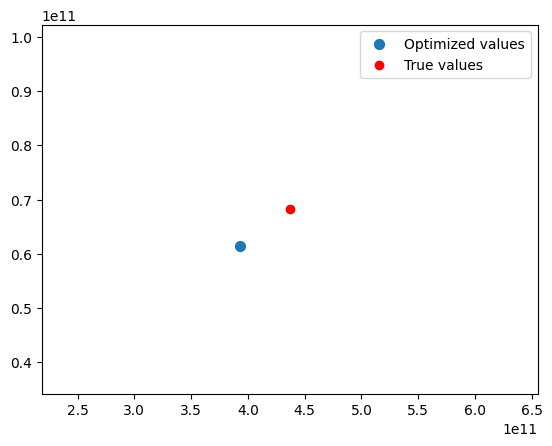

In [22]:
plt.scatter(res.value[0], res.value[1],  label="Optimized values", s=50)
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.MN_params.M * code_units.code_mass.to(u.Msun),color="red", label="True values")
plt.xlim(params.NFW_params.Mvir*(0.5) * code_units.code_mass.to(u.Msun), params.NFW_params.Mvir*(1.5) * code_units.code_mass.to(u.Msun))
plt.ylim(params.MN_params.M*(0.5) * code_units.code_mass.to(u.Msun), params.MN_params.M*(1.5) * code_units.code_mass.to(u.Msun))
plt.legend()

# TWO PARAMS: NFW

In [39]:
params_sim = params

@jit
def run_simulation(Mvir, r_s):
    Mvir = 10**Mvir

    phi1_min, phi1_max = -90, 10
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass),
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 5
    mask_correct_interpolation_forward = phi1_forward_valid > - 80

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward & mask_evaluate_inside_track_backward) + jnp.sum(mask_stream_forward &mask_evaluate_inside_track_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
r_s = (params.NFW_params.r_s*(3/4) * u.kpc).to(code_units.code_length).value
loss, grad = jax.value_and_grad(run_simulation, argnums=(0, 1))(Mvir, r_s) 
print("Gradient of the total mass of the Mvir of NFW and r_s:\n", grad)
print("Loss:\n", loss)  
n_sim = 100

M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4) * code_units.code_mass.to(u.Msun), params.NFW_params.Mvir*(8/4) * code_units.code_mass.to(u.Msun), n_sim-1) # Adjust range based on expected values
r_s_values = jnp.linspace(params.NFW_params.r_s*(1/4) * code_units.code_length.to(u.kpc), params.NFW_params.r_s*(8/4) * code_units.code_length.to(u.kpc), n_sim-1) # Adjust range based on expected values

M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)])])  # Append the true Mvir value
r_s_values = jnp.concatenate([r_s_values, jnp.array([params.NFW_params.r_s * code_units.code_length.to(u.kpc)])])  # Append the true r_s value
# Ensure both arrays are sorted
# M_tot_values = jnp.log10(jnp.sort(M_tot_values))
# M_MN_values = jnp.sort(M_MN_values)

M_tot_values = jnp.log10(jnp.sort(M_tot_values))
r_s_values = jnp.sort(r_s_values)


# Create a meshgrid
M_tot_grid, r_s_grid = jnp.meshgrid(M_tot_values, r_s_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
r_s_flat = r_s_grid.flatten()

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.lax.with_sharding_constraint(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
r_s_sharded = jax.lax.with_sharding_constraint(r_s_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, r_s = input
    return jax.value_and_grad(run_simulation, argnums=(0, 1))(Mvir, r_s)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, r_s_sharded), 
                         batch_size=1000)

loss = loss.reshape(M_tot_grid.shape)

Gradient of the total mass of the Mvir of NFW and r_s:
 (Array(nan, dtype=float32), Array(nan, dtype=float32))
Loss:
 -0.0


Text(0.5, 1.0, 'loss_landscape')

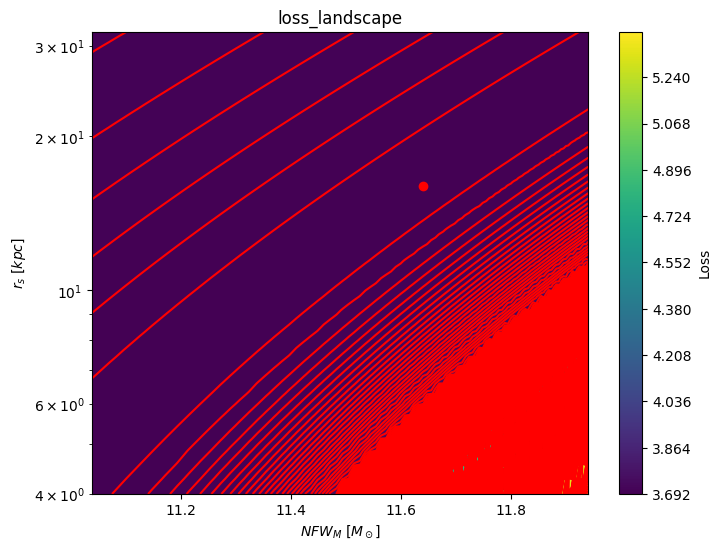

In [47]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
CS = plt.contourf(M_tot_values, r_s_values, jnp.log10(-loss.T), levels=1000, cmap="viridis")
plt.colorbar(label="Loss")

CS2 = plt.contour(CS, levels=CS.levels, colors='r')
# plt.imshow(jnp.log10(-loss.squeeze().T), extent=(M_tot_values.min(), M_tot_values.max(), M_MN_values.min(), M_MN_values.max()), origin='lower', aspect='auto', cmap='viridis')

plt.scatter(jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), params.NFW_params.r_s * code_units.code_length.to(u.kpc), color="red", label="True values")
plt.yscale('log')
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$r_{s}$ [$kpc$]")
plt.title("loss_landscape")

<Figure size 1000x800 with 0 Axes>

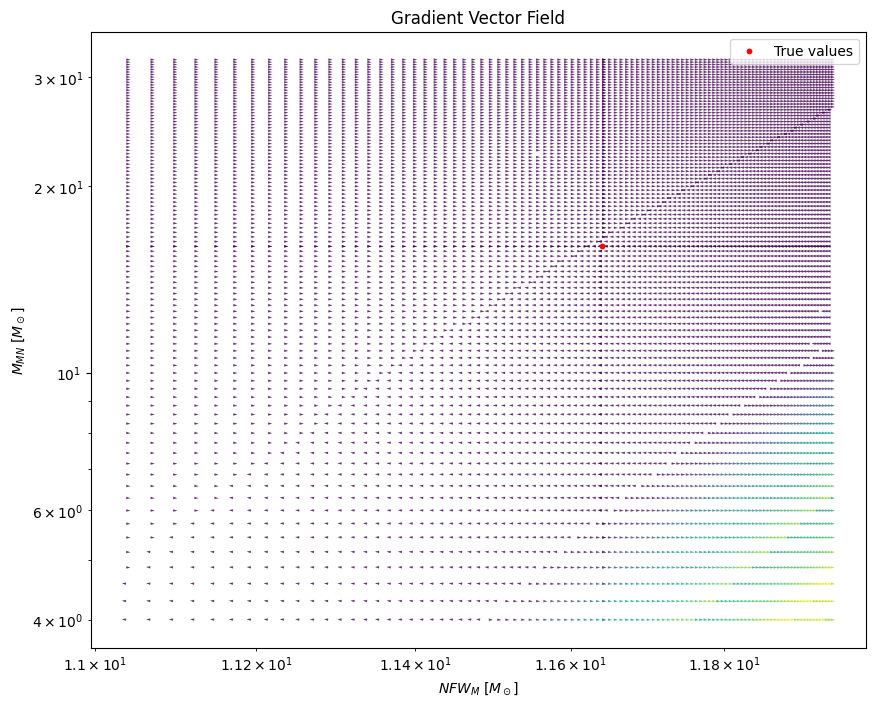

In [50]:
# Subsample for cleaner arrow plot
skip = 1 # Plot every 5th arrow to avoid clutter
M_tot_sub = M_tot_grid[::skip, ::skip]
r_sub = r_s_grid[::skip, ::skip]
grad_mvir_sub = grad[0].reshape(M_tot_grid.shape)[::skip, ::skip]
grad_mmn_sub = grad[1].reshape(M_tot_grid.shape)[::skip, ::skip]

plt.figure(figsize=(10, 8))
# Normalize the gradients
grad_magnitude = jnp.sqrt(grad_mvir_sub**2 + grad_mmn_sub**2)
grad_mvir_norm = jnp.where(grad_magnitude > 0, grad_mvir_sub / grad_magnitude, 0)
grad_mmn_norm = jnp.where(grad_magnitude > 0, grad_mmn_sub / grad_magnitude, 0)

plt.figure(figsize=(10, 8))
plt.quiver(M_tot_sub, r_sub, grad_mvir_norm, grad_mmn_norm, 
           grad_magnitude, alpha=0.8, cmap='viridis')

plt.scatter(jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
           params.NFW_params.r_s * code_units.code_length.to(u.kpc),
           color="red", label="True values", s=10, zorder=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$M_{MN}$ [$M_\odot$]")
plt.title("Gradient Vector Field")
plt.legend()
plt.show()

# 2 Parameters MN

In [29]:
params_sim = params

@jit
def run_simulation(M_MN, a):
    M_MN = 10**M_MN

    phi1_min, phi1_max = -90, 10
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a = a * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 5
    mask_correct_interpolation_forward = phi1_forward_valid > - 80

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward & mask_evaluate_inside_track_backward) + jnp.sum(mask_stream_forward &mask_evaluate_inside_track_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M_MN = (params.MN_params.M*(3/4) * u.Msun).to(code_units.code_mass).value
a = (params.MN_params.a*(3/4) * u.kpc).to(code_units.code_length).value
loss, grad = jax.value_and_grad(run_simulation, )(M_MN, a) 
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  
n_sim = 100

M_MN_values = jnp.linspace(params.MN_params.M*(1/4) * code_units.code_mass.to(u.Msun), params.MN_params.M*(8/4) * code_units.code_mass.to(u.Msun), n_sim-1) # Adjust range based on expected values
a_values = jnp.linspace(params.MN_params.a*(1/4) * code_units.code_length.to(u.kpc), params.MN_params.a*(8/4) * code_units.code_length.to(u.kpc), n_sim-1) # Adjust range based on expected values

M_MN_values = jnp.concatenate([M_MN_values, jnp.array([params.MN_params.M * code_units.code_mass.to(u.Msun)])])  # Append the true M_MN value
a_values = jnp.concatenate([a_values, jnp.array([params.MN_params.a * code_units.code_length.to(u.kpc)])])  # Append the true a value
# Ensure both arrays are sorted
# M_tot_values = jnp.log10(jnp.sort(M_tot_values))
# M_MN_values = jnp.sort(M_MN_values)

M_MN_values = jnp.log10(jnp.sort(M_MN_values))
a_values = jnp.sort(a_values)

# Create a meshgrid
M_MN_grid, a_grid = jnp.meshgrid(M_MN_values, a_values, indexing="ij")

# Flatten the grid for vectorized computation
M_MN_flat = M_MN_grid.flatten()
a_flat = a_grid.flatten()

mesh = Mesh(np.array(jax.devices()), ("i",))
M_MN_sharded = jax.lax.with_sharding_constraint(M_MN_flat, NamedSharding(mesh, PartitionSpec("i")))
a_sharded = jax.lax.with_sharding_constraint(a_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    M_MN, a = input
    return jax.value_and_grad(run_simulation, argnums=(0, 1))(M_MN, a)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(M_MN_sharded, a_sharded), 
                         batch_size=1000)

loss = loss.reshape(M_tot_grid.shape)

Gradient of the total mass of the Mvir of NFW:
 nan
Loss:
 -0.0


In [31]:
loss

Array([[-4973.534 , -4973.6606, -4973.787 , ..., -4987.7373, -4987.882 ,
        -4988.0254],
       [-4970.964 , -4971.092 , -4971.221 , ..., -4985.754 , -4985.9062,
        -4986.057 ],
       [-4967.7173, -4967.8457, -4967.975 , ..., -4983.8057, -4983.9663,
        -4984.126 ],
       ...,
       [-5128.044 , -5124.506 , -5121.017 , ..., -4953.4355, -4952.821 ,
        -4952.22  ],
       [-5133.7573, -5130.1387, -5126.575 , ..., -4954.6504, -4954.0127,
        -4953.39  ],
       [-5139.553 , -5135.859 , -5132.2134, ..., -4955.8975, -4955.236 ,
        -4954.591 ]], dtype=float32)

Text(0.5, 1.0, 'loss_landscape')

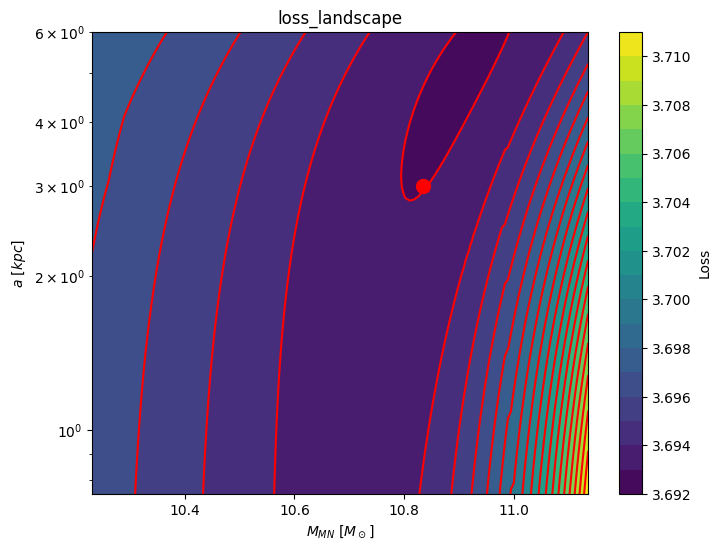

In [38]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
CS = plt.contourf(M_MN_values, a_values, jnp.log10(-loss.T), levels=20, cmap="viridis")
plt.colorbar(label="Loss")
CS2 = plt.contour(CS, levels=CS.levels, colors='r')
# plt.imshow(jnp.log10(-loss.squeeze().T), extent=(M_tot_values.min(), M_tot_values.max(), M_MN_values.min(), M_MN_values.max()), origin='lower', aspect='auto', cmap='viridis')


plt.scatter(jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
              params.MN_params.a * code_units.code_length.to(u.kpc),
           color="red", label="True values", s=100, zorder=5)
plt.yscale('log')
plt.xlabel("$M_{MN}$ [$M_\odot$]")
plt.ylabel("$a$ [$kpc$]")
plt.title("loss_landscape")

<Figure size 1000x800 with 0 Axes>

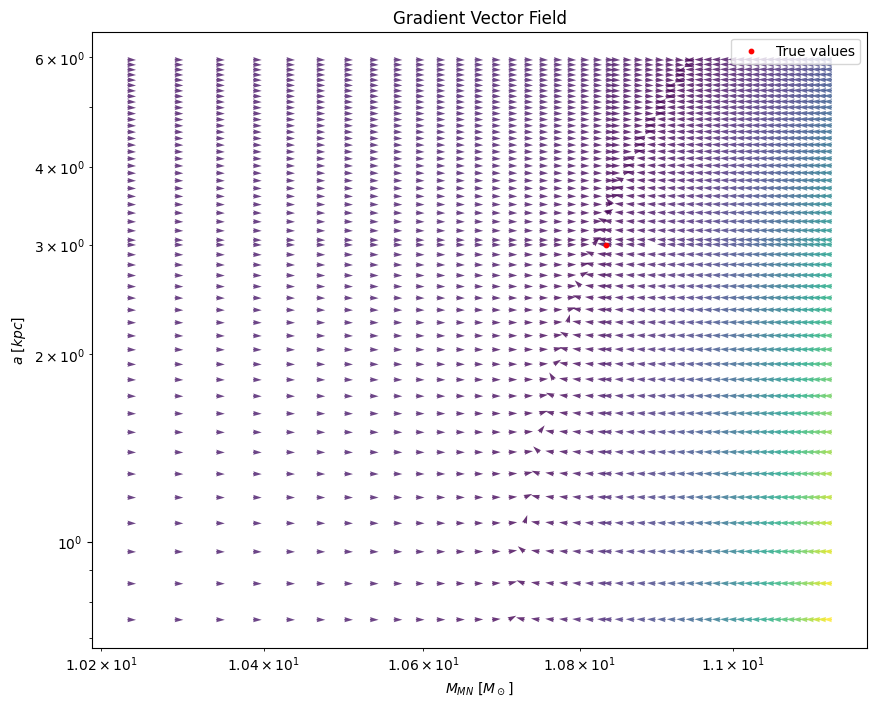

In [36]:
# Subsample for cleaner arrow plot
skip = 2 # Plot every 5th arrow to avoid clutter
M_MN_sub = M_MN_grid[::skip, ::skip]
a_sub = a_grid[::skip, ::skip]
grad_mvir_sub = grad[0].reshape(M_MN_grid.shape)[::skip, ::skip]
grad_mmn_sub = grad[1].reshape(M_MN_grid.shape)[::skip, ::skip]

plt.figure(figsize=(10, 8))
# Normalize the gradients
grad_magnitude = jnp.sqrt(grad_mvir_sub**2 + grad_mmn_sub**2)
grad_mvir_norm = jnp.where(grad_magnitude > 0, grad_mvir_sub / grad_magnitude, 0)
grad_mmn_norm = jnp.where(grad_magnitude > 0, grad_mmn_sub / grad_magnitude, 0)

plt.figure(figsize=(10, 8))
plt.quiver(M_MN_sub, a_sub, grad_mvir_norm, grad_mmn_norm, 
           grad_magnitude, alpha=0.8, cmap='viridis')

plt.scatter(jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
              params.MN_params.a * code_units.code_length.to(u.kpc),
           color="red", label="True values", s=10, zorder=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("$M_{MN}$ [$M_\odot$]")
plt.ylabel("$a$ [$kpc$]")
plt.title("Gradient Vector Field")
plt.legend()
plt.show()

# MCMC

In [9]:
params

SimulationParams(G=np.float64(0.00040486519363225977), t_end=np.float64(1.0), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(3.1622776601683795)), NFW_params=NFWParams(Mvir=np.float64(43683325.0), r_s=np.float64(1.6)), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=np.float64(6819390.2782346755), a=np.float64(0.30000000000000004), b=np.float64(0.028000000000000004)), PSP_params=PSPParams(M=450136.537506545, alpha=1.8, r_c=np.float64(0.19)), Logarithmic_params=LogarithmicParams(v0=220.0, q=0.9))

In [10]:
import jax.numpy as jnp
import jax
from jax import jit


import pandas as pd

from chainconsumer import Chain, ChainConsumer, Truth


import blackjax
from tqdm import tqdm

params_sim = params

true_GD1_observation_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/true.npz'
observation = jnp.array(np.load(true_GD1_observation_path)['x']).reshape(1000, 6)
true_theta = jnp.array(np.load(true_GD1_observation_path)['theta'])

# ----------------------------- Load observation & precompute target densities ----------------
true_GD1_observation_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/true.npz'
_obs = np.load(true_GD1_observation_path)
stream_data = jnp.array(_obs['x']).reshape(1000, 6)  # will be used only to compute target densities
true_theta = jnp.array(_obs['theta'])


@jit
def run_simulation(params):

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        new_params = params_sim._replace(
                        NFW_params=params_sim.NFW_params._replace(
                            Mvir = params['M_NFW']*u.Msun.to(code_units.code_mass),
                            r_s = params['r_s']*u.kpc.to(code_units.code_length),),
                        MN_params=params_sim.MN_params._replace(
                            M = params['M_MN']*u.Msun.to(code_units.code_mass),
                            a = params['a_MN']*u.kpc.to(code_units.code_length),),
                        t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)

    return stream_coordinate_com


@jit
def stream_loglikelihood(stream_coordinate_com, ):
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]
    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    
    coord_indices=jnp.array([2, 3, 4, 5])

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)

    #
    sigma = jnp.array([0.5, 10., 2., 2. ]) 
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood
    
    
@jit
def evaluate_loglikelihood(theta_1, ):

        # print(f"In the corrector: theta_1 shape: {theta_1.shape}, target shape: {target.shape}")
        output = run_simulation(theta_1)

        # return stream_likelihood(model_stream=output, obs_stream=observation, obs_errors=jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001]))
        return stream_loglikelihood(stream_coordinate_com=output, )

# True parameter values (without code_units transformation)
true_params = jnp.array([
    4.3683325e11,          # NFW Mvir (Msun)
    16.0,                  # NFW r_s (kpc)
    68_193_902_782.346756, # MN M (Msun)
    3.0,                   # MN a (kpc)
])

# Prior bounds for each parameter
prior_bounds = jnp.array([
    [4.3683325e11 * 0.25, 4.3683325e11 * 2.0],  # NFW Mvir: 1/4 to 2x true
    [16.0 * 0.25, 16.0 * 2.0],    # NFW r_s: 1/4 to 2x true (kpc)
    [68_193_902_782.346756 * 0.25, 68_193_902_782.346756 * 2.0],  # MN M: 1/4 to 2x true
    [3.0 * 0.25, 3.0 * 2.0],      # MN a: 1/4 to 2x true (kpc)
])  # Shape: (7, 2) for [min, max] bounds

def draw_from_prior(key):
    """Draw samples from uniform prior."""
    key, subkey = jax.random.split(key)
    u = jax.random.uniform(subkey, shape=(4,))
    
    # Transform uniform [0,1] to [min, max] for each parameter
    samples = prior_bounds[:, 0] + u * (prior_bounds[:, 1] - prior_bounds[:, 0])
    samples = {'M_NFW': samples[0], 'r_s': samples[1], 'M_MN': samples[2], 'a_MN': samples[3]}
    return samples

param_order = ['M_NFW', 'r_s', 'M_MN', 'a_MN']
@jit
def dict_to_array(theta_dict):
    return jnp.array([theta_dict[k] for k in param_order])

@jit
def array_to_dict(theta_array):
    return {k: theta_array[i] for i, k in enumerate(param_order)}

@jit
def evaluate_log_prior(theta):
    """Evaluate log prior density (uniform)."""
    # Check if all parameters are within bounds 
    # theta = jnp.array([theta['t_end'], theta['Mtot'], theta['a_Plummer'], theta['M_NFW'], theta['r_s'], theta['M_MN'], theta['a_MN']])
    # in_bounds = jnp.all((theta >= prior_bounds[:, 0]) & (theta <= prior_bounds[:, 1])) 
    in_bounds = jnp.all(jnp.array([
        (theta['M_NFW'] >= prior_bounds[0, 0]) & (theta['M_NFW'] <= prior_bounds[0, 1]),
        (theta['r_s'] >= prior_bounds[1, 0]) & (theta['r_s'] <= prior_bounds[1, 1]),
        (theta['M_MN'] >= prior_bounds[2, 0]) & (theta['M_MN'] <= prior_bounds[2, 1]),
        (theta['a_MN'] >= prior_bounds[3, 0]) & (theta['a_MN'] <= prior_bounds[3, 1]),
    ]))
    
    # For uniform distribution: log(density) = -log(volume)
    # Volume = product of interval widths
    log_volume = jnp.sum(jnp.log(prior_bounds[:, 1] - prior_bounds[:, 0]))
    
    # Return -inf if out of bounds, -log_volume if in bounds
    return jnp.where(in_bounds, -log_volume, -jnp.inf)
    # return -log_volume


def draw_from_proposal(key, theta, sigma2_prop):
    key, sk = jax.random.split(key)
    theta_prime = jax.random.normal(sk, shape=theta.shape) * jnp.sqrt(sigma2_prop) + theta
    return theta_prime, key

@jit
def evaluate_log_posterior_grad(theta):
    """Compute gradient of log posterior."""
    
    def log_posterior(theta):
        log_prior = evaluate_log_prior(theta)
        log_like = evaluate_loglikelihood(theta)
        return log_prior + log_like
    
    # Get both value and gradient
    log_post_val, grad = jax.value_and_grad(log_posterior)(theta)
    return log_post_val, grad

@jit
def evaluate_log_posterior(theta):
    log_prior = evaluate_log_prior(theta)
    log_like = evaluate_loglikelihood(theta_1 = theta, )
    return log_prior + log_like

In [ ]:
# Initialize the state
posterior_SBI = np.load('../../../../sbi_diff_sim/sbi-sim/logs/OdisseoCrossAttentionSetTransformer_small_AllParameters_Position_uniforprior_2e5_TSIT5/pictures/predicted_theta_test_set.npz')['predicted_theta'][0]
mean = np.mean(posterior_SBI, axis=0)
init_positions = mean[[3, 4, 5, 6]]
init_positions[[0, 2]] = 10**init_positions[[0, 2]]
init_positions = array_to_dict(init_positions)

warmup = blackjax.window_adaptation(blackjax.nuts, evaluate_log_posterior, progress_bar=True)

rng_key = jax.random.PRNGKey(35)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, init_positions, num_steps=50)

nuts = blackjax.nuts(evaluate_log_posterior, **parameters)

Running window adaptation


In [43]:
parameters

{'step_size': Array(1.0317978e-05, dtype=float32, weak_type=True),
 'inverse_mass_matrix': Array([1., 1., 1., 1.], dtype=float32)}

In [44]:
from blackjax.util import run_inference_algorithm

final_state, history_state = run_inference_algorithm(
    rng_key=jax.random.PRNGKey(42),
    inference_algorithm=nuts,
    num_steps=20,
    initial_state=state,
    progress_bar=True,
)

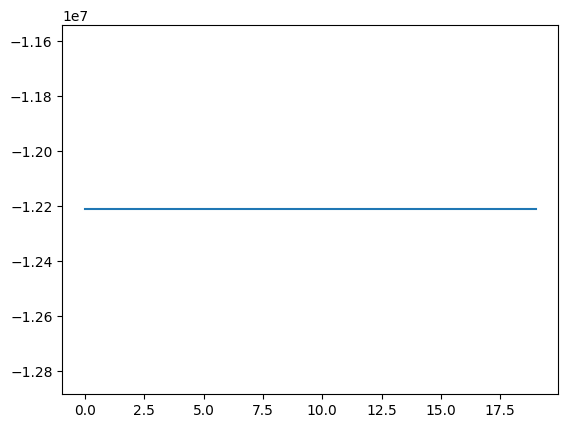

In [45]:
plt.plot(history_state[0].logdensity)

In [11]:
history_state

(HMCState(position={'M_MN': Array([1.0481619e+11, 1.0481619e+11, 1.0481619e+11, 1.0481619e+11,
        1.0481619e+11, 1.0481619e+11, 1.0481619e+11, 1.0481619e+11,
        1.0481619e+11, 1.0481619e+11, 1.0481619e+11, 1.0481619e+11,
        1.0481619e+11, 1.0481619e+11, 1.0481619e+11, 1.0481619e+11,
        1.0481619e+11, 1.0481619e+11, 1.0481619e+11, 1.0481619e+11],      dtype=float32), 'M_NFW': Array([2.823468e+11, 2.823468e+11, 2.823468e+11, 2.823468e+11,
        2.823468e+11, 2.823468e+11, 2.823468e+11, 2.823468e+11,
        2.823468e+11, 2.823468e+11, 2.823468e+11, 2.823468e+11,
        2.823468e+11, 2.823468e+11, 2.823468e+11, 2.823468e+11,
        2.823468e+11, 2.823468e+11, 2.823468e+11, 2.823468e+11],      dtype=float32), 'a_MN': Array([3.0839128, 3.3597007, 3.3597007, 3.3597007, 3.3597007, 3.3597007,
        3.3597007, 3.3597007, 3.3597007, 3.3597007, 3.3597007, 3.3597007,
        3.3597007, 3.3597007, 3.3597007, 3.3597007, 3.3597007, 3.3597007,
        3.3597007, 3.3597007], d

In [14]:
def convert_to_dataframe_filtered(positions_dict, is_accepted_mask):
    """Convert dictionary of arrays to DataFrame, filtering by acceptance. Works for single or multiple chains."""
    
    # Handle both single chain and multi-chain cases
    if len(positions_dict['t_end'].shape) == 1:
        # Single chain case: reshape to [1, num_samples]
        num_chains = 1
        num_samples = positions_dict['t_end'].shape[0]
        
        # Reshape all arrays to add chain dimension
        positions_reshaped = {}
        for param_name, values in positions_dict.items():
            positions_reshaped[param_name] = values.reshape(1, -1)
        
        # Reshape acceptance mask
        is_accepted_reshaped = is_accepted_mask.reshape(1, -1)
        
    else:
        # Multi-chain case: use as-is
        num_chains = positions_dict['t_end'].shape[0]
        num_samples = positions_dict['t_end'].shape[1]
        positions_reshaped = positions_dict
        is_accepted_reshaped = is_accepted_mask
    
    print(f"Original samples: {num_chains} chains × {num_samples} samples = {num_chains * num_samples}")
    
    all_samples = []
    
    for chain_id in range(num_chains):
        # Get acceptance mask for this chain
        chain_accepted = is_accepted_reshaped[chain_id, :]  # Boolean mask for this chain
        
        # Extract samples for this chain
        chain_data = {}
        for param_name, values in positions_reshaped.items():
            # Only keep accepted samples
            chain_data[param_name] = values[chain_id, chain_accepted]
        
        # Count accepted samples for this chain
        n_accepted = jnp.sum(chain_accepted)
        print(f"  Chain {chain_id}: {n_accepted}/{num_samples} accepted ({n_accepted/num_samples*100:.1f}%)")
        
        # Create DataFrame for this chain (only accepted samples)
        if n_accepted > 0:  # Only add if there are accepted samples
            df_chain = pd.DataFrame(chain_data)
            df_chain['chain_id'] = chain_id
            df_chain['original_sample_id'] = jnp.where(chain_accepted)[0]  # Track original indices
            
            all_samples.append(df_chain)
    
    if not all_samples:
        print("⚠️ Warning: No accepted samples found!")
        return pd.DataFrame()
    
    # Combine all chains
    combined_df = pd.concat(all_samples, ignore_index=True)
    total_accepted = len(combined_df)
    total_original = num_chains * num_samples
    
    print(f"📊 Total accepted samples: {total_accepted}/{total_original} ({total_accepted/total_original*100:.1f}%)")
    
    return combined_df

# Usage remains the same - works for both single and multiple chains
positions = history_state[0].position
is_accepted = history_state[0].is_accepted

# Convert with filtering (now works for single chain too)
df_all_filtered = convert_to_dataframe_filtered(positions, is_accepted)

# Rest of the code remains exactly the same
burn_in = 10
thin_factor = 1  

if len(df_all_filtered) > 0:
    df_processed = df_all_filtered[
        (df_all_filtered['original_sample_id'] >= burn_in) & 
        (df_all_filtered['original_sample_id'] % thin_factor == 0)
    ].copy()
    
    # Remove metadata columns for plotting
    df_plot = df_processed.drop(['chain_id', 'original_sample_id'], axis=1)
    
    # Rename columns for nice LaTeX formatting
    df_plot.columns = ['M_NFW', 'r_s', 'M_MN', 'a_MN']
    
    print(f"📈 Final samples for plotting: {len(df_plot)}")
    
    # Create ChainConsumer plot with true values
    from chainconsumer import Chain, ChainConsumer, Truth
    
    # Create Chain object
    chain = Chain(samples=df_plot, name="MCMC Posterior (Filtered)")
    
    # Create ChainConsumer object
    c = ChainConsumer()
    c.add_chain(chain)
    
    # Add true values
    true_values_dict = {
        'M_MN': 68_193_902_782.346756,
        'M_NFW': 4.3683325e11,
        'a_MN': 3.0,
        'r_s': 16.0,
    }
    
    truth = Truth(location=true_values_dict, name="True Parameters")
    c.add_truth(truth)
    
    # Create corner plot
    print("🎨 Creating corner plot...")
    fig = c.plotter.plot()
    plt.show()
    
    # Print summary statistics
    print("\n📊 MCMC Summary (filtered accepted samples):")
    print(f"Number of samples: {len(df_plot)}")
    print(f"Number of chains: {df_processed['chain_id'].nunique()}")
    
    # Calculate parameter statistics
    param_names = ['$M_{MN}$ [M$_\odot$]', '$M_{NFW}$ [M$_\odot$]', '$M_{Plummer}$ [M$_\odot$]', '$a_{MN}$ [kpc]', '$a_{Plummer}$ [kpc]', '$r_s$ [kpc]', '$t_{end}$ [Gyr]']
    
    print("\nParameter estimates (mean ± std):")
    print("-" * 60)
    for i, param in enumerate(param_names):
        col_name = df_plot.columns[i]
        mean_val = df_plot[col_name].mean()
        std_val = df_plot[col_name].std()
        true_val = list(true_values_dict.values())[i]
        
        print(f"{param:20s}: {mean_val:.6e} ± {std_val:.6e}")
        print(f"{'True value':20s}: {true_val:.6e}")
        print(f"{'Bias (σ)':20s}: {(mean_val - true_val) / std_val:.2f}")
        print("-" * 60)
    
else:
    print("❌ No samples available for plotting after filtering!")

AttributeError: 'HMCState' object has no attribute 'is_accepted'

# SOLVING ISSUES

In [11]:
# Initialize the state
posterior_SBI = np.load('../../../../sbi_diff_sim/sbi-sim/logs/OdisseoCrossAttentionSetTransformer_small_AllParameters_Position_uniforprior_2e5_TSIT5/pictures/predicted_theta_test_set.npz')['predicted_theta'][0]
mean = np.mean(posterior_SBI, axis=0)
init_positions = mean[[3, 4, 5, 6]]
init_positions[[0, 2]] = 10**init_positions[[0, 2]]
init_positions = array_to_dict(init_positions)

# Check if your posterior is well-behaved
test_theta = init_positions
log_post, grad = jax.value_and_grad(evaluate_log_posterior)(test_theta)

print(f"Log posterior: {log_post}")
print(f"Gradient: {grad}")
print(f"Gradient norms: {jnp.sqrt(sum(g**2 for g in grad.values()))}")


# Check parameter scales
param_scales = jnp.array([init_positions[k] for k in ['M_NFW', 'r_s', 'M_MN', 'a_MN']])
print(f"Parameter scales: {param_scales}")
print(f"Scale ratios: {param_scales.max() / param_scales.min()}")

Log posterior: -117780.6484375
Gradient: {'M_MN': Array(2.8350598e-07, dtype=float32), 'M_NFW': Array(4.6608925e-08, dtype=float32), 'a_MN': Array(-2229.368, dtype=float32), 'r_s': Array(-1717.371, dtype=float32)}
Gradient norms: 2814.150634765625
Parameter scales: [5.3141465e+11 2.0570101e+01 8.0288555e+10 3.6173007e+00]
Scale ratios: 146909167616.0


In [ ]:
# Transform parameters to similar scales (all around 0-10 range)

# Define scaling factors based on typical values
SCALE_FACTORS = {
    'M_NFW': 1e11,     # Scale masses to units of 10^11 Msun
    'r_s': 10.0,       # Scale lengths to units of 10 kpc  
    'M_MN': 1e11,      # Scale masses to units of 10^11 Msun
    'a_MN': 1.0,       # Keep kpc scale as is
}

@jit
def transform_to_scaled(theta_physical):
    """Transform physical parameters to scaled parameters."""
    return {
        'M_NFW_scaled': theta_physical['M_NFW'] / SCALE_FACTORS['M_NFW'],
        'r_s_scaled': theta_physical['r_s'] / SCALE_FACTORS['r_s'],
        'M_MN_scaled': theta_physical['M_MN'] / SCALE_FACTORS['M_MN'],
        'a_MN_scaled': theta_physical['a_MN'] / SCALE_FACTORS['a_MN'],
    }

@jit 
def transform_to_physical(theta_scaled):
    """Transform scaled parameters back to physical parameters."""
    return {
        'M_NFW': theta_scaled['M_NFW_scaled'] * SCALE_FACTORS['M_NFW'],
        'r_s': theta_scaled['r_s_scaled'] * SCALE_FACTORS['r_s'],
        'M_MN': theta_scaled['M_MN_scaled'] * SCALE_FACTORS['M_MN'],
        'a_MN': theta_scaled['a_MN_scaled'] * SCALE_FACTORS['a_MN'],
    }

# Update your likelihood function to work with scaled parameters
@jit
def evaluate_log_posterior_scaled(theta_scaled):
    # Transform to physical parameters
    theta_physical = transform_to_physical(theta_scaled)
    
    # Evaluate likelihood with physical parameters
    log_prior = evaluate_log_prior(theta_physical)
    log_like = evaluate_loglikelihood(theta_physical)
    
    # Add Jacobian correction for the transformation
    # For linear scaling: log|J| = sum(log(scale_factors))
    log_jacobian = jnp.sum(jnp.log(jnp.array(list(SCALE_FACTORS.values()))))
    
    return log_prior + log_like + log_jacobian 

# Update prior bounds for scaled parameters
scaled_prior_bounds = jnp.array([
    [4.3683325e11 * 0.25 / SCALE_FACTORS['M_NFW'], 4.3683325e11 * 2.0 / SCALE_FACTORS['M_NFW']],  # M_NFW_scaled
    [16.0 * 0.25 / SCALE_FACTORS['r_s'], 16.0 * 2.0 / SCALE_FACTORS['r_s']],                      # r_s_scaled  
    [68_193_902_782.346756 * 0.25 / SCALE_FACTORS['M_MN'], 68_193_902_782.346756 * 2.0 / SCALE_FACTORS['M_MN']], # M_MN_scaled
    [3.0 * 0.25 / SCALE_FACTORS['a_MN'], 3.0 * 2.0 / SCALE_FACTORS['a_MN']],                      # a_MN_scaled
])

@jit
def evaluate_log_prior_scaled(theta_scaled):
    """Evaluate log prior for scaled parameters."""
    param_array = jnp.array([theta_scaled['M_NFW_scaled'], theta_scaled['r_s_scaled'], 
                            theta_scaled['M_MN_scaled'], theta_scaled['a_MN_scaled']])
    
    in_bounds = jnp.all((param_array >= scaled_prior_bounds[:, 0]) & 
                       (param_array <= scaled_prior_bounds[:, 1]))
    
    log_volume = jnp.sum(jnp.log(scaled_prior_bounds[:, 1] - scaled_prior_bounds[:, 0]))
    
    return jnp.where(in_bounds, -log_volume, -jnp.inf)

# Initialize with scaled parameters
posterior_SBI = np.load('../../../../sbi_diff_sim/sbi-sim/logs/OdisseoCrossAttentionSetTransformer_small_AllParameters_Position_uniforprior_2e5_TSIT5/pictures/predicted_theta_test_set.npz')['predicted_theta'][0]
mean = np.mean(posterior_SBI, axis=0)
init_positions_physical = mean[[3, 4, 5, 6]]
init_positions_physical[[0, 2]] = 10**init_positions_physical[[0, 2]]
init_positions_physical = array_to_dict(init_positions_physical)

# Transform to scaled parameters
init_positions_scaled = transform_to_scaled(init_positions_physical)

# Test the scaled posterior
log_post_scaled, grad_scaled = jax.value_and_grad(evaluate_log_posterior_scaled)(init_positions_scaled)

print(f"Scaled log posterior: {log_post_scaled}")
print(f"Scaled gradient: {grad_scaled}")
print(f"Scaled gradient norms: {jnp.sqrt(sum(g**2 for g in grad_scaled.values()))}")

# Check scaled parameter values (should all be similar magnitude)
scaled_values = jnp.array([init_positions_scaled[k] for k in init_positions_scaled.keys()])
print(f"Scaled parameter values: {scaled_values}")
print(f"Scaled parameter ratio: {scaled_values.max() / scaled_values.min()}")

Scaled log posterior: -117716.1796875
Scaled gradient: {'M_MN_scaled': Array(28350.596, dtype=float32), 'M_NFW_scaled': Array(4660.8926, dtype=float32), 'a_MN_scaled': Array(-2229366.5, dtype=float32), 'r_s_scaled': Array(-1717370.2, dtype=float32)}
Scaled gradient norms: 2814295.75
Scaled parameter values: [8.0288553e-01 5.3141465e+00 3.6173009e-03 2.0570101e-02]
Scaled parameter ratio: 1469.0916748046875


In [ ]:
# # Use scaled parameters for MCMC
# warmup = blackjax.window_adaptation(blackjax.nuts, evaluate_log_posterior_scaled, progress_bar=True)

# rng_key = jax.random.PRNGKey(35)
# rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

# # Run warmup with scaled parameters and more steps
# (state, parameters), _ = warmup.run(warmup_key, init_positions_scaled, num_steps=10)

# nuts = blackjax.nuts(evaluate_log_posterior_scaled, **parameters)

# print(f"Adapted step size: {parameters['step_size']}")
# print(f"Adapted mass matrix: {parameters['inverse_mass_matrix']}")

Running window adaptation
